## Active Learning and Predictive Coding - A Case Study with Enron Spam Classification

In this demo we will run through an example task of _binary classification_ in _active learning_ setting. The fundamental goal is to showcase the series of steps or sub-tasks that are involved in **predictive coding**. Before committing to code, we will briefly cover some of terominology involved:

**Passive/Supervised Learning**: Typical setting in machine learning problems where we have labeled dataset.

**Active Learning (AL)**: A branch of machine learning where the goal is to build effective queries to reduce label complexity while interactiving with a labeler.

**Oracle**: (Usually) Human labeler involved in active learning.

**Query**: An instance (data point) selected by active learner, for which oracle is requested to provide label (that's why active learning is also called _query learning_ (Settles, 2009)).

**Pool-based Active Learning**: Most used form of AL in real-world problems where we have a large collection of unlabeled data and a small portion of labeled set. Other two are _Query Synthesis AL_ and _Stream-based AL_, which are not suitable for our problem.

**Batch-mode Active Learning**: An extension to Pool-based AL where instead of single query we select an optimal set (a batch) of queries.

**Label Complexity**: Number of label requests sufficient to achieve a given accuracy.

**Model Complexity**: Number of (free) parameters of a learning algorithm (model).

In [42]:
# imports

# built-in imports
import os

# installed packages imports
import numpy as np
import matplotlib.pyplot as plt

from gensim.utils import unpickle
from gensim.corpora import Dictionary
from scipy import sparse
from sklearn.model_selection import train_test_split

# local package imports
import models
import metrics
import plots

from samples import random_trials_prevalence
from samples import clopper_pearson_ci

from scripts.preprocess import main as preprocess_main
from scripts.prepare_features import main as features_main

from simulation import ActiveSimulation as CAL
from simulation import ReviewStageSimulation as Review

import ldds
import features

join = os.path.join

%matplotlib inline

## Data

We use [Enron-Spam](http://www2.aueb.gr/users/ion/data/enron-spam/) as our dataset. From the data page, processed documents were downloaded and manually organized into two sub-folders, **spam** and **ham**. This dataset has _16,545 ham_ and _17,157 spam_ documents.

Since the number of relevant documents in E-discovery are much less compared to non-relevant documents so, there is an inherent imbalance in datasets therefore, we randomly select a sub-set of 2000 ham documents (proxy as relevant) against all spam documents. The sub-sampled dataset is available as compressed file in demo repository.

Uncompress **data.tar.gz** and create data folder such that it only has two sub-folders as _spam_ and _ham_

In [43]:
# set paths

DATA_DIR = "data"
OUTPUT_DIR = "output"
FEATURES_DIR = "features"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)

## Preprocessing

This is generic step and not specific to active learning, its included for the sake of complete, standalone and reproducible results from data files.

   - **Input**: DATA_DIR containing "spam/", "ham/" folders
   - **Preprocessing**: for details of pre-processing steps involved, check `scripts/preprocess.py`
   - **Output**: 3 files under OUTPUT_DIR

       - **processed_enron_docs_as_lines.txt**: each processed file is converted to single line and considered as one document (used for tfidf and doc2vec features)

       - **docid2path.pkl**: mapping of each processed document id to their original file path on system (note: ids will not having any gaps, sequentially from 1 to N)

       - **processed_enron_sents_as_lines.txt**: here documents are processed at sentences level and only useful for training a word2vec like model to generate word embeddings


In [44]:
# set it to "False" if you've already pre-processed the files and just re-running notebook with other tweaks
PREPROCEES = False

if PREPROCEES:
    # TODO: add progress reporting
    preprocess_main(DATA_DIR, OUTPUT_DIR)

## Features Generation

Like preprocessing this step of features creation is generic step but included for the sake of reproducibility

   - **Input**: processed files from previous step

   - **Features**: TF-IDF, Vanilla word2vec, doc2vec only required features can be set as needed

   - **Output**: several files under FEATURES_DIR depending on
     features selected

       - **(tfidf_vocab, tfidf_model, tfidf_X.npz)**: TF-IDF vocab, model and features files

       - **(w2v_model, w2v_X.npy)**: word2vec model and features files

       - **(d2v_model, d2v_X.npy)**: doc2vec model and features files


In [45]:
# set it to "False" if you've already generated features files and just re-running notebook with other tweaks
FEATURES = False

if FEATURES:
    features_main(
        join(OUTPUT_DIR, 'processed_enron_docs_as_lines.txt'),
        join(OUTPUT_DIR, 'processed_enron_sents_as_lines.txt'),
        FEATURES_DIR,
        True, True, False
    ) # the last three flags in order enables TF-IDF, word2vec and doc2vec features respectively

### Term Frequency - Inverse Document Frequency (TF-IDF)

In our experiments we will make use of tf-idf as our only features due to certain properties which we will soon cover. It is popular weighted _Bag-of-Words (BoW)_ approach. Here, we used [SMART](https://en.wikipedia.org/wiki/SMART_Information_Retrieval_System) **ntc** weighting scheme offered by gensim's [TF-IDF module](https://radimrehurek.com/gensim/models/tfidfmodel.html).

Tf-idf is often used as baseline in research papers and/or combined with several other features. Although the topic of _features engineering_ is out of this notebook's scope but it is worth mentioning few properties of tf-idf that makes it effective:

- Since data lies in very high-dimensional feature space (scales to size of vocabulary), the data points are usually linearly independent. Linear separability allows the use of linear models to solve the problem. One way to think about this is analogous to [kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) in SVM, where we aim to transform data from its original space to kernel space making it linearly independen
- Linear SVM performs best with tf-idf and finds an optimal decision boundary
- High degree of sparsity allows efficient training and lower memory footprint with sparse storage schemes (such as CSR)
- Again sparsity naturally offers feature selection so we don't need to manually apply any features reduction techniques
- Due to facts mentioned above it is clear that the use of non-linear models (or kernels) will not only cause difficultly in training on large data in high-dimensional space but also reach sub-optimal results

However, we are not concluding that tf-idf are best features, they will perform poorly where its hard to learn a clear boundary between two classes or the problem at hand is not very distinctive among the target labels. They do serve as a strong baseline but dense features (e.g. word embeddings) combined with meta-data features and complex models can outperform them.

In our case study we will stick with tf-idf unless otherwise explicitly mentioned.

In [46]:
# load pre-pared data

def load_X(X_path, is_sparse):
    if is_sparse:
        return sparse.load_npz(X_path)
    else:
        return np.load(X_path)


def load_y(docid2path_path):
    docid2path = unpickle(docid2path_path)
    y = list()
    for path in docid2path.values():
        if 'ham' in path.split(os.sep):
            y.append(1)
        else:
            y.append(0)
    return np.asarray(y, dtype=int)

# original features to label mapping <X, y>
data_X = load_X(join(FEATURES_DIR, 'tfidf_X.npz'), True)
data_y = load_y(join(OUTPUT_DIR, 'docid2path.pkl'))

In [47]:
# let's look into features matrix X and labels distribution

num_data_points, feature_dim = data_X.shape
num_spam_docs, num_ham_docs = np.bincount(data_y)

print("Total number of data points after pre-processing: {}".format(num_data_points))
print("Features dimension (size of vocab): {}".format(feature_dim))
print("Number of ham documents (positive / 1 class): {}".format(num_ham_docs))
print("Number of spam documents (negative / 0 class): {}".format(num_spam_docs))

Total number of data points after pre-processing: 17879
Features dimension (size of vocab): 33634
Number of ham documents (positive / 1 class): 1995
Number of spam documents (negative / 0 class): 15884


## Supervised Learning

To make a fair comparison, we will first solve the problem under supervised framework and then move to active learning. We use same model for both settings and same data splits. Moreover, a test set is kept aside for final evaluation and comparison between the two.

In real-world active learning application we will not have access to test set therefore the need to create a test set is only to make a fair comparison between two learning settings. Supervised learning experiments here are non-exhasutive as the main goal is comparison with AL. This part is not applicable to a real predictive coding system.

We use linear SVM with SGD training as our default model. For parameteres detail, please check `models.py`.

In [48]:
# create train-test splits
X, X_test, y, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=2018)

print("Train size: {} | Classes distribution: {}".format(X.shape[0], np.bincount(y)))
print("Test size: {} | Classes distribution: {}".format(X_test.shape[0], np.bincount(y_test)))

Train size: 14303 | Classes distribution: [12686  1617]
Test size: 3576 | Classes distribution: [3198  378]


**NOTE**: Test set is not used for training.

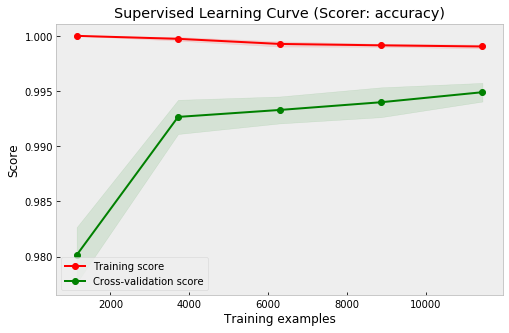

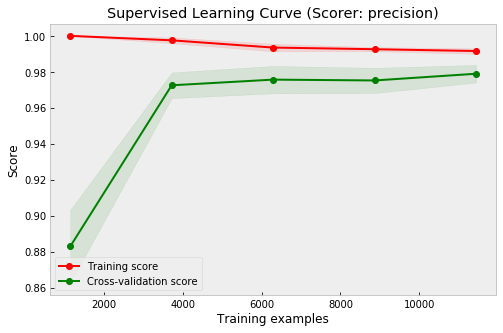

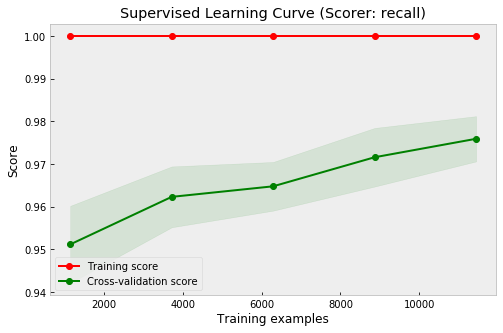

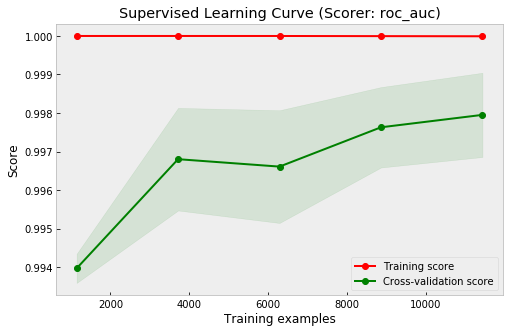

In [49]:
# plot learning curves with different metrics
lc_scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

for scoring in lc_scoring:
    # load default model: Linear SVM with SGD
    clf_supervised = models.default_model()
    plt_handle = plots.plot_learning_curve(
        clf_supervised, 'Supervised Learning Curve (Scorer: {})'.format(scoring),
        X, y, cv=5, scoring=scoring
    )
    plt_handle.show()

In [50]:
# train supervised classifier and save results on test set
clf_supervised = models.default_model()

# train model
clf_supervised.fit(X, y)

# test predictions
sup_y_test_preds = clf_supervised.predict(X_test)

# store results
supervised_results = {
    'accuracy': metrics.accuracy(y_test, sup_y_test_preds),
    'precision': metrics.precision(y_test, sup_y_test_preds),
    'recall': metrics.recall(y_test, sup_y_test_preds),
    'gmeans': metrics.g_means(y_test, sup_y_test_preds),
    'auc': metrics.auc(y_test, sup_y_test_preds),
    'cohen-kappa': metrics.user_machine_agreement(y_test, sup_y_test_preds)
}

In [51]:
print("Supervised Learning - Test Metrics")
print("Accuracy: %0.3f" % supervised_results['accuracy'])
print("Precision: %0.3f" % supervised_results['precision'])
print("Recall: %0.3f" % supervised_results['recall'])
print("G-means: %0.3f" % supervised_results['gmeans'])
print("Agreement: %0.3f" % supervised_results['cohen-kappa'])

Supervised Learning - Test Metrics
Accuracy: 0.995
Precision: 0.979
Recall: 0.976
G-means: 0.987
Agreement: 0.975


#### Model Evaluation Metrics (Measures)

To assess model's performance and quality we use a set of metrics, we will briefly gloss over them:

**Confusion Matrix**: A matrix representing true and predicted labels as:

|  | Predicted Label 1 | Predicted Label 0 |
| --- | --- | --- |
| True Label 1 | True Positive (TP) | False Negative (FN) |
| True Label 0 | False Positive (FP) | True Negative (TN) |

**Accuracy**: $$\frac{TP + TN}{TP + FP + FN + TN}$$

**Precision**: $$\frac{TP}{TP+FP}$$

**Recall (Sensitivity)**: $$\frac{TP}{TP+FN}$$

**Specificity**: $$\frac{TN}{TN+FP}$$

**True Positive Rate (TPR)**: $$= sensitivity$$

**False Positive Rate (FPR)**: $$= 1 - specificity$$

**G-means**: $$\sqrt{sensitivity \times specificity}$$

Generally speaking, accuracy is not a good measure for imbalanced datasets because if model is ill trained then most of the time its making majority class predictions. In that sense, precision, recall, and area under reciver operating curve (AUC-ROC) are good metrics. Ertekin et al. (2007) makes use of g-means in an unbalanced scenario for active learning.


**NOTE**: These quality/performance measures are model specific and _not_ predictive coding specific.

## Active Learning for Predictive Coding

Active learning is a protocol for supervised machine learning, in which a learning algorithm sequentially requests the labels of selected data points from a large pool of unlabeled data. The objective in active learning is to produce a highly-accurate classifier, ideally using fewer labels than passive learning to achieve the same (Hanneke, 2009). Among other types of active learning, the focus here is on pool-based active learning where the general setup has:

- Large pool of unlabeled data
- Some labeled data (however, not strictly needed)
- An expert, oracle, providing labels
- Learning model(s)

With some definition abuse, it can be fairly said that active learning is a specialized type of sampling technique. One critical difference from statistical sampling is that we are not interested in approximating or modeling data distribution (like in MCMC methods) here but sampling the data points which optimizes (minimizes) the label complexity. 

Active learning plays an important role in predictive coding (PC), where the goal is to find relevant documents in e-discovery from large pool of unlabeled documents. AL is part of PC but PC itself is a framework. To understand, we will summarize three most popular technologies namely TAR (Technology Assisted Review) 1.0, 2.0 and 3.0 (much of the information presented here is taken from B. Dimm, 2015).

### TAR Glossary

**Control Set**: A set of reviewed documents that are used to measure the quality of training. 

**Seed Data / Training Data**: Documents to initiate learning

**Prevalence (Richness)**: Percentage of all docs that are relevant.

**Recall**: Percentage of relevant docs found.

**Precision**: Percentage of docs predicted to be relevant that actually are relevant.

**PR @ k**: Precision and recall measured at top-k review documents.

**Relevance**: A measure representing the relevance of documents.

**Review**: The process of documents review after or during learning.

### TAR 1.0

1. Review training docs (with random or non-random)
2. Use control set to determine whether training should end (Back to (1) if additional training is worthwhile)
3. Sort remaining docs by relevance score for review/production
4. Sample/test to ensure sufficient recall

### TAR 2.0 (Continuous Active Learning - CAL)

1. Review very small set of training docs (single relevant doc is enough)
2. Update predictions and sort remaining docs by relevance score
3. Review small number of docs with highest relevance scores (Back to (2) unless not many relevant docs left)
4. Sample/test to ensure sufficient recall

**NOTE**:

- System continues to learn throughout
- No separation between training and review
- Huge number of relevant training docs

### TAR 3.0 (CAL on Cluster Centers - Applicable to Clustify)

1. Form conceptual clusters (narrow focus, fixed radius, agglomerative)
2. Review very small set of training docs (single relevant doc is enough)
3. Update predictions for cluster centers and sort by relevance score
4. Review small number of cluster centers with highest relevance scores (Back to (3) unless not many relevant cluster centers left)
5. Generate predictions for full population, then you have a choice:
   1. Produce docs without review (unless potentially privileged)
   2. Produce docs with high relevance scores without review, and perform standard CAL on remainder (review top docs, update predictions, and iterate)
   3. Review all docs that are candidates for production using standard CAL
6. Sample/test to ensure sufficient recall

**NOTE**:

- Training and review are separate, like TAR 1.0
- No control set needed
- Option to produce docs without review if desired
- Free prevalence estimate

Before proceeding to our approach, the table below provides comparison of TAR 1.0, 2.0, and 3.0 (B. Dimm, 2015):

<img src="imgs/tar-comparisons-bill.jpg" width="800px">


### Our Approach to TAR

1. Select documents at random (or use cluster sampling) and review them to identify _k_ relevant documents (prevalence is _estimated_ during this sampling phase)
2. Set this as seed data and initialize training (**learning to classify** documents into relevant and irrelevant classes, _not_ **learning to rank**) 
3. Predict and sample document with Active Learning and request label
4. Train and track validation performance (Back to (3) until we run out of queries budget or reach specified validation performance)
5. Sort documents as per model's relevance predictions and start review
   1. Take top-k batches sequentially
   2. Monitor PR @ k, document rank distribution and prioritized review
   3. Repeat (1) & (2) till estimated number of relevant documents are discovered or a desired recall is achieved

We observe noteable differences between existing techniques and our approach, in particular, existing methods strongly mention relevance score and importance of sorting on it which makes one think if these methods belong to a different branch of machine learning called [_learning to rank_](https://en.wikipedia.org/wiki/Learning_to_rank). It is widely used in _information retrieval_ literature for building search engines, where the goal is to show the most relevant results, to a user query, at top. In such systems _relevance feedback_ plays a vital role to show best results, in fact Brainspace mentions, in its whitepaper (Lewis, 2017), usage and importance of of one classical algorithm called [Rocchio for relevance feedback](https://nlp.stanford.edu/IR-book/html/htmledition/relevance-feedback-and-query-expansion-1.html). The learning objective is different and therefore learning algorithms are different as well, divided into two types, _pairwise_ and _listwise_ methods (look [here](https://en.wikipedia.org/wiki/Learning_to_rank#List_of_methods) for a list of ranking models) of which RankSVM is commonly used. While there are some traces of usage of relevance ranking models usage in predictive coding, we couldn't clearly construct a reason of _why_ its required. It is to be answered and we leave this discussion open for further research. Our approach is simpler in this sense and focuses on learning to classify while optimizing queries with active learning. 

Up next, we will look into CAL and PC demo.

## Phase - I

In this phase we demonstrate the process of selecting: seed documents, learning model and active learning query strategy, we call this as Continous Active Learning (CAL) phase where the main learning happens.

#### Active Learning Simulation

Before moving forward, its important to have a visual look at pool-based active learning framework. Figure 1. shows an active cycle iteration, where $\mathcal{U}$ is unlabeled pool of data, $\mathcal{L}$ is labeled data, _learner_ is learning model, _query_ is data point for which the label is requested, $<x,?>$ is query representation pair by feature vector $x$ and unknown label $?$, _oracle_ is human expert providing unknown label as $y$ and $<x,y>$ is labeled query representation which is then added to labeled pool $\mathcal{L}$ for training.

<img src="imgs/pool-based-al-burr-settles.jpg" width="800px">

In AL simulation we conduct experiments when we actually have labeled data so anytime a query's label is requested from _oracle_ it is supplied by machine itself by a simple lookup corresponding to that document.


#### Preparing Seed Data

By seed data we simply mean the initial labeled data set $\mathcal{L}_{initial}$ that is used for warm start training of learning algorithm. It is not an _explicit_ requirement but it definitely helps learner to make a good start. The size of seed data is a free parameter and can be configured by user. According to [Relativity AL document](https://help.relativity.com/9.6/Content/Relativity/Active_Learning/Active_Learning.htm) (under special considerations, 5th bullet) they require at least 5 relevant and 5 irrelevant documents, making a total of 10 documents to initialize training. We leave it to user to set _how many relevant documents they want to start with_ and the process of selecting such documents can be done in two ways:

- Random Sampling
- Keywords Sampling
- Cluster Sampling

##### Random Sampling

Selecting documents at random is costly but it is an unbiased and fair approach which generally reflects the data population. The challenge to find a specified number of documents depends on prevalence and the lower the prevalence is the higher the cost is to find relevant documents. To aid the user in case of random sampling we offer a tool that helps in making an estimate of _number of docs_ required to look at to find certain _number of relevant docs_ irrespective of features used. Below we demonstrate its hypothetical use case.  

**NOTE**: The code below will take time with default params.

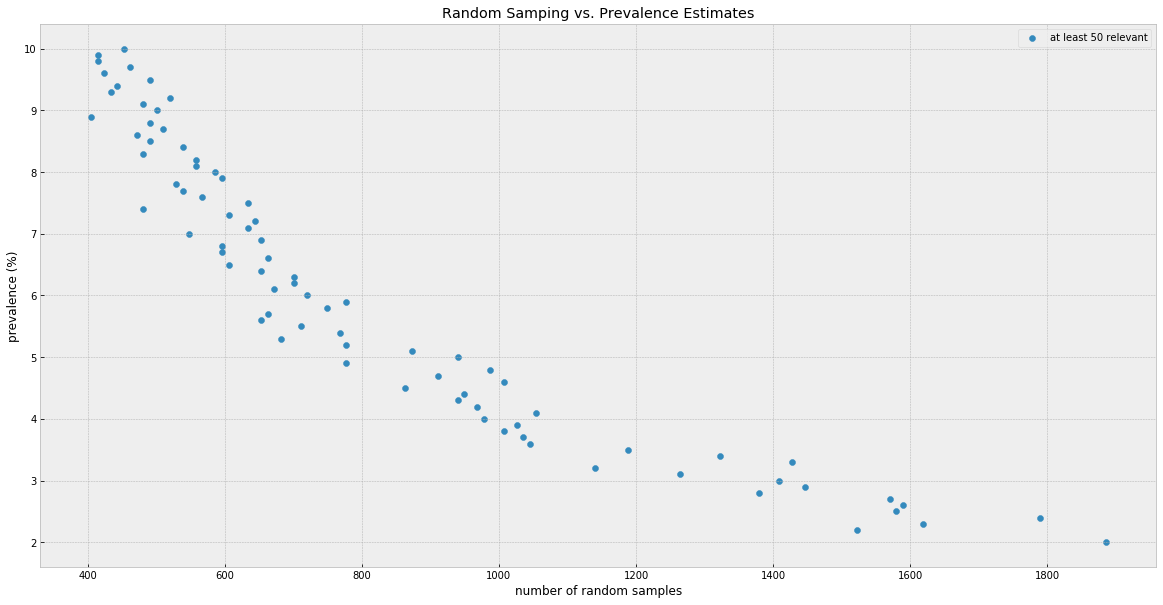

In [11]:
# size of data (number of total documents)
N = 1000000

# number of relevant documents to find
S = 50

# minimum prevalence to consider (in %)
p_min = 0.1

# maximum prevalence to consider (in %)
p_max = 10

# number of steps to consider between given prevalence range
p_steps = 100

# at least sample this many documents
d_min = 100

# at max sample this many documents (if not provided, default will be used i.e. 5% of N)
d_max = 2000

# number of steps to consider between document sampling range
d_steps = None

init_rs_samples = random_trials_prevalence(
    n=N, successes=S, min_prev=p_min, max_prev=p_max, prev_steps=p_steps, 
    min_sample_size=d_min, max_sample_size=d_max, sample_steps=d_steps
)

The figure aids the user in making an informed decision about number of documents to sample in order to achieve a certain number of relevant documents for a sweep of prevalences. This also help in early estimate of prevalence e.g. if we have sampled 1000 documents and haven't been able to get 50 relevant documents then its clear that our prevalence is less than 4%. Conversely, if there is apriori knowledge about prevalence then one can look at that prevalence and sample the number of documents as per the graph.

In sampling estimates its important to have [confidence interval (CI)](https://en.wikipedia.org/wiki/Confidence_interval) which informs, with certain confidence level, about the range of values among which true value of unknown will lie. In example above, if we sampled 1200 documents to get 50 relevant documents then our prevalence estimate is 4.1% but how confident we are about this estimate and whether or not if we resample (after replacement) will we be able to achieve 50 relevant docs in 1200 samples? To answer this we need to have a CI tool that can help us. First we need to understand the nature of trials, at each sample we check whether or not we got relevant documents, mapping to one of two outcomes i.e. "success" or "failure" which naturally maps to [Bernoulli trials](https://en.wikipedia.org/wiki/Bernoulli_trial) and therefore follows [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) (due to repeated trials). This leads to narrow our CI methods to [Binomial proportion CI](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) where we have two types of approaches, _approximate_ and _exact_. In cases where [prevalence is very low then exact methods are considered superior](http://www.cluster-text.com/confidence_interval.php) which leads us to focus on [Clopper-Pearson interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval). Without further technical details, let's look our CI for hypothetical values of 50:1200 with **95%** confidence: 

In [52]:
ci_low, ci_high = clopper_pearson_ci(50, 1200)

print("Lower bound on prevalence estimate: %0.3f%%" % (ci_low * 100))
print("Upper bound on prevalence estimate: %0.3f%%" % (ci_high * 100))

Lower bound on prevalence estimate: 3.108%
Upper bound on prevalence estimate: 5.457%


Which tells us that we can say, with 95% confidence, that the true value of prevalence with 50 relevant documents in 1200 trials (4.1%) lies between 3.1% to 5.5%. This CI estimate is agnostic to population size and conservative in calculations due to exactness. Furthermore, if we just make our estimates based on small number of successes then the range will be pretty wide e.g.

In [53]:
# CI on finding 1 relevant document in 50 trials
ci_low, ci_high = clopper_pearson_ci(1, 50)

print("Lower bound on prevalence estimate: %0.3f%%" % (ci_low * 100))
print("Upper bound on prevalence estimate: %0.3f%%" % (ci_high * 100))

Lower bound on prevalence estimate: 0.051%
Upper bound on prevalence estimate: 10.647%


Which surely doesn't help us much, so the takeaway is: the more sampling the narrow the interval with high degree of certainity but definitely the higher the cost to review.

These tools are added to support traditional life-cycle of PC and our approach, as it will get clear later, is insensitive to prevalence estimates during learning phase. However, review phase has dependencies on these estimates.

##### Keywords Sampling

This is search based sampling, a user might want to retrieve document based on their knowledge of keywords and label them. Its the most efficient way of developing seed data but has inherent issues such as bias, which often leads to sub-optimal models. This technique is also used extensively in predictive coding and well understood so we will skip going into its details or using it in the demo.   

##### Cluster Sampling

Due to its advance and optional nature we will discuss it towards the end of notebook in _additional section_ and showcase how we can improve our hit-rate to find relevant documents compared to random sampling with this approach.

**NOTE**: The purpose of creating seed dataset is to only help model make a good start for CAL. A user can come up with seed data with any technique in their arsenal and then kick start CAL. In this sense, CAL is independent of documents sampling for seed data but it is important to realize that biased methods give poor estimates of population and can lead model to overfit a certain concept (e.g. represented by keywords) and bias agnostic methods such as random sampling are well representing population but can become very costly. Cluster sampling is a middle ground but its feature dependent as we will see.

For now, we will move to **CAL**.

## CAL Simulation Demo

In [54]:
# create CAL object
cal = CAL()

In [55]:
# set learning model
cal_model = models.default_model()

#### Model Properties

- Linear Support Vector Machine
- Optimization: Stochastic Gradient Descent (SGD)
- Loss: [Hinge](https://en.wikipedia.org/wiki/Hinge_loss)
- Regularization: L2
- Label Weighting: Balanced
- Supports Online Learning
- Implementation: [scikit-learn SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [56]:
# initialize
cal.initialize(
    X=X, model=cal_model, y=None, query='US', mode='simulate', 
    y_ideal=y, num_relevant_seed=10, progressive_validation=True, 
    pr_rate=5
)

#### CAL Initialization Parameters

**X**: Feature matrix of size **`num_documents x features_dimension`**

**model**: Learning model

**y**: Labels, if any

**query**: Active learning algorithm (query strategy) (here we set it to `US` => Uncertainty Sampling, we will discuss AL algorithms later)

**mode**: Mode of active learning, can be one of **`simulate`** or **`active`**, where former allows experimenting with labeled datasets and oracle is mimicked by the provided label, latter allows learning to be done interactively by requesting labels from user (not tested)

**y_ideal**: A noiseless mapping of each document to its label **`0`** as _irrelevant_ or **`1`** as _relevant_, required when `mode`=`active`

**num_relevant_seed**: How many relevant documents to sample for initial seeding. In a purely `active` mode this will be performed by oracle

**progressive_validation**: Whether to allow collection of test examples from user labeled examples as a measure to reflect classifier's generalization ability. Right now, it is set as an optional parameter but ideally it should be _fixed_ to track classifier performance without compromising too much on performance or enhacing label complexity. It can be argued that progressive validation may not reflect true loss but it is a good estimate since we don't have access to all the labels. It can also be used for hyperparameter tuning but then using it as loss estimate will be unfair. Other key properties of such set includes:

- The fact that examples are collected as we progress, this naturally collects evolving concepts and thus catering for concept drifts or priors shift
- User knowledge is well represented by this set as their review decisions are encoded in latent fashion so a good performance on this set is indictive of model's learning ability and adjusting to user knowledge
- Active learning algorithms are designed to pick informative and representitive samples (it depends on method used) which are challenging for classifier so being to able to generalize on them makes case for discintive and discriminative learning
- Downside: Since we are picking challenging points which, if learned, could improve classifier's performance so there is also a risk that validation metrics don't improve and can lead to misleading results centric to those points only and are not representing general population (meaning that it is possible for model to perform very poor on validation but generalize well on unlabeled instances which if labeled were classified correctly) but it can also be argued that if validation sampling rate `pr_rate` is modest then we are improving model's learning by higher proportions to not (let `pr_rate` be 5, meaning every 5th instance is picked for validation, in this scenario 4/5 times we are improving and only 1/5 times we are compromising for performance estimation; the higher the pr_rate, the lower the risk of compromising the learning ability) 

**pr_rate**: Frequency at which to collect validation examples. For example, a value of 5 means that every 5th label we query from user it will be assigned to validation set no matter positive or negative

In [57]:
# let's look into seed stats
seed_indexes_neg = [index for index, props in cal.dataset.index2props.items() if props.is_seed == True and props.y_true == 0]
seed_indexes_pos = [index for index, props in cal.dataset.index2props.items() if props.is_seed == True and props.y_true == 1]

SN = len(seed_indexes_neg)
SP = len(seed_indexes_pos)

print("===========================================")
print("Random sampling stats and estimates")
print("===========================================")

print("Total examples in seed dataset: {}".format(SN+SP))
print("Number of relevant docs in seed: {}".format(SP))
print("Number of irrelevant docs in seed: {}".format(SN))
print("Estimated prevalence: %0.3f%%" % (cal.est_prevelance * 100))
print("Estimated number of relevant docs: {}".format(cal.est_relevant))

actual_rel_count = sum(1 for yi in y if yi == 1)

print("Actual number of relevant docs including seed: {}".format(actual_rel_count))

ci_low, ci_high = cal.ci

print("Lower bound on prevalence estimate: %0.3f%%" % (ci_low * 100))
print("Upper bound on prevalence estimate: %0.3f%%" % (ci_high * 100))

init_labeled_len = cal.dataset.len_labeled()
init_unlabeled_len = cal.dataset.len_unlabeled()

print()
print("===========================================")
print("CAL start state stats")
print("===========================================")
print("Labeled pool size: {}".format(init_labeled_len))
print("Unlabeled pool size: {}".format(init_unlabeled_len))

Random sampling stats and estimates
Total examples in seed dataset: 63
Number of relevant docs in seed: 10
Number of irrelevant docs in seed: 53
Estimated prevalence: 15.873%
Estimated number of relevant docs: 2270
Actual number of relevant docs including seed: 1617
Lower bound on prevalence estimate: 7.883%
Upper bound on prevalence estimate: 27.260%

CAL start state stats
Labeled pool size: 63
Unlabeled pool size: 14240


In [58]:
T = 1000 # queries budget
cal.run(T)

Query# 10
Query# 20
Query# 30
Query# 40
Query# 50
Query# 60
Query# 70
Query# 80
Query# 90
Query# 100
Query# 110
Query# 120
Query# 130
Query# 140
Query# 150
Query# 160
Query# 170
Query# 180
Query# 190
Query# 200
Query# 210
Query# 220
Query# 230
Query# 240
Query# 250
Query# 260
Query# 270
Query# 280
Query# 290
Query# 300
Query# 310
Query# 320
Query# 330
Query# 340
Query# 350
Query# 360
Query# 370
Query# 380
Query# 390
Query# 400
Query# 410
Query# 420
Query# 430
Query# 440
Query# 450
Query# 460
Query# 470
Query# 480
Query# 490
Query# 500
Query# 510
Query# 520
Query# 530
Query# 540
Query# 550
Query# 560
Query# 570
Query# 580
Query# 590
Query# 600
Query# 610
Query# 620
Query# 630
Query# 640
Query# 650
Query# 660
Query# 670
Query# 680
Query# 690
Query# 700
Query# 710
Query# 720
Query# 730
Query# 740
Query# 750
Query# 760
Query# 770
Query# 780
Query# 790
Query# 800
Query# 810
Query# 820
Query# 830
Query# 840
Query# 850
Query# 860
Query# 870
Query# 880
Query# 890
Query# 900
Query# 910
Query# 9

#### Queries Budget

One key area of research in active learning is to formalize a stopping criteria (when to stop asking for labels) or in technical terms having bounded label complexity for an active algorithm. However, the real stopping criterion for practical applications is based on economic or other external factors, which likely come well before an intrinsic learner-decided threshold. In e-discovery lawyers can decide when to stop the learning procedure and move to review or they can track performance on progressive validation (test) set, it depends on many factors so just for now, we run it with certain number of queries $T$. In a realistic application test metrics and related learning curves will be displayed in real-time to help make a decision. In latter discussion of algorithms we will indicate such algorithms that offer these bounds.

#### CAL Evaluation

We divide evaluation in two-folds:

- Test Evaluation: Model performance on progressively collected examples (which were not used for training)
- Unlabeled Evaluation (only applicable in simulation mode): Model performance on unseen and unlabeled data

##### Test Evaluation

In [59]:
val_X, val_y, _ = cal.dataset.get_labeled_data('valid')

num_val_pos = sum(val_y)
num_val_neg = len(val_y) - num_val_pos

print("Number of relevant document in test set: {}".format(num_val_pos))
print("Number of irrelevant document in test set: {}".format(num_val_neg))

Number of relevant document in test set: 22
Number of irrelevant document in test set: 177


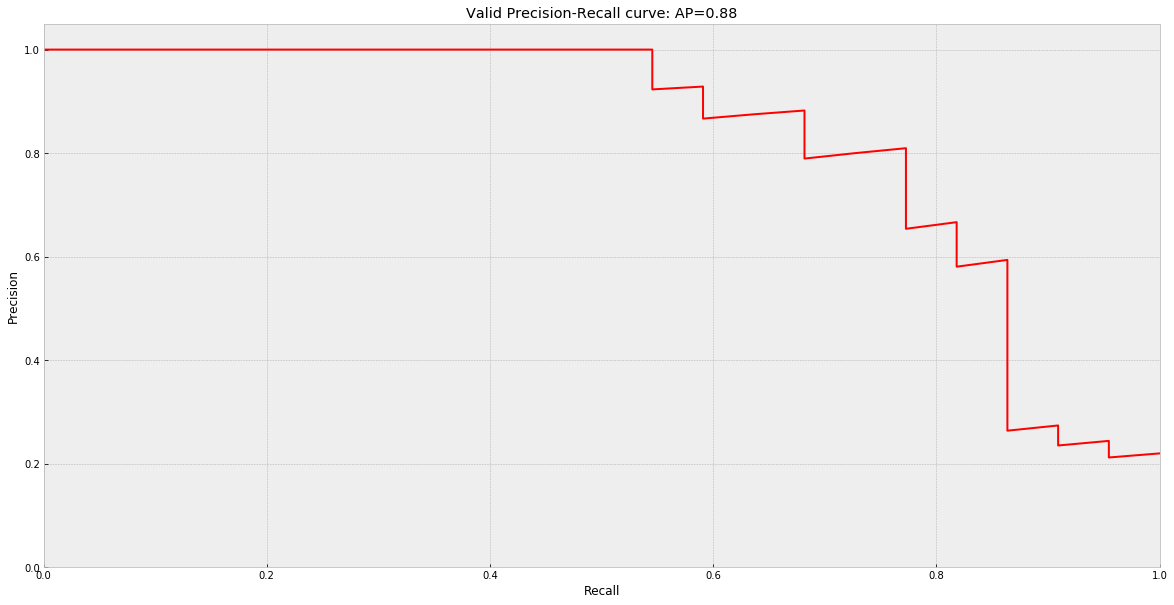

In [60]:
# compute validation scores
val_X_scores = cal.model.decision_function(val_X)
# plot Precision-Recall sweep
plots.pr_curve(val_y, val_X_scores, 'valid', False)

The PR curve informs that we can achieve 80% recall at a greater precision of 80% but for higher recalls, precision drop signficantly. The curve is approximately like ideal curve and area under curve is quite high as well ~90%. 

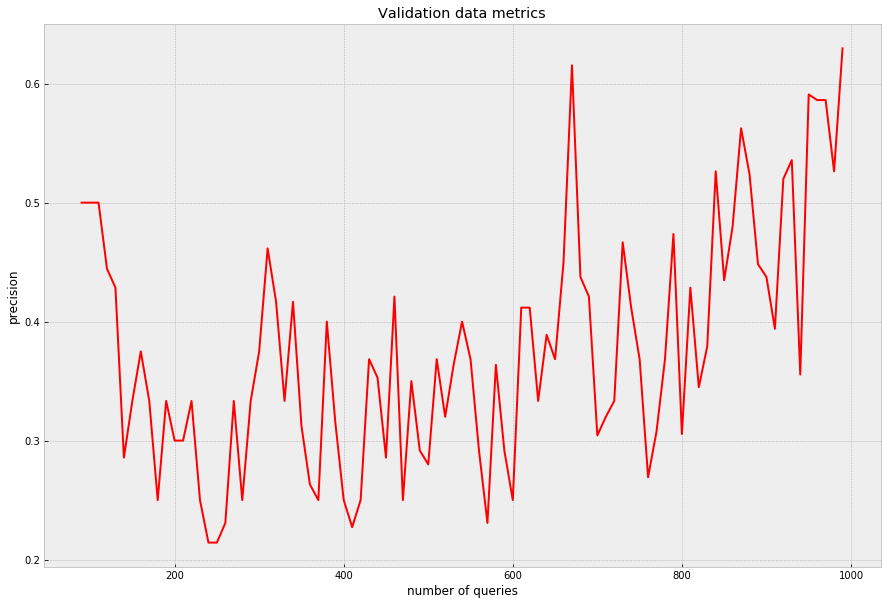

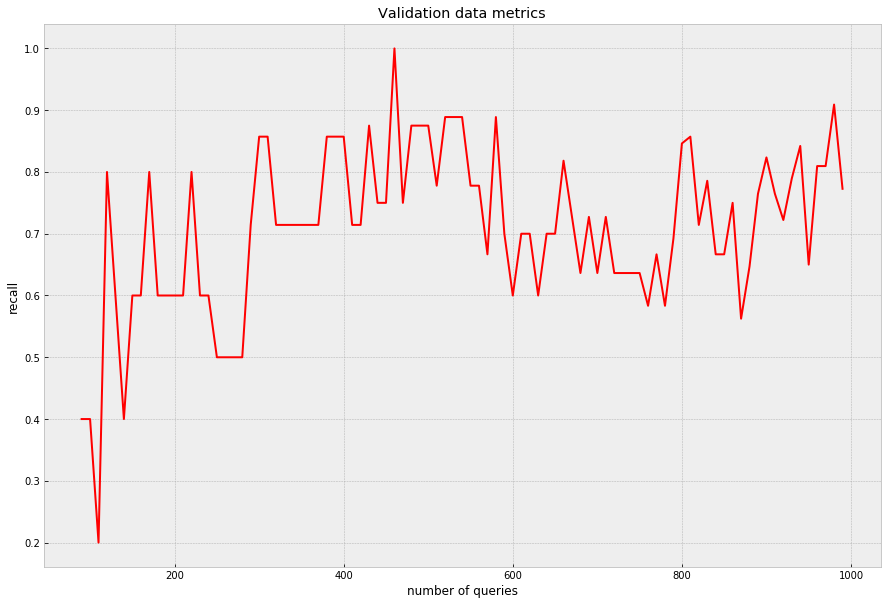

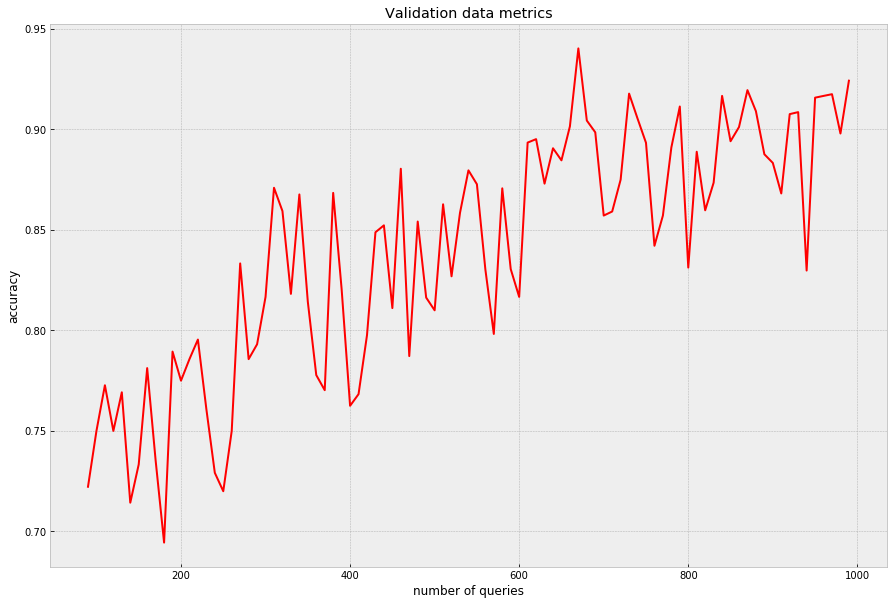

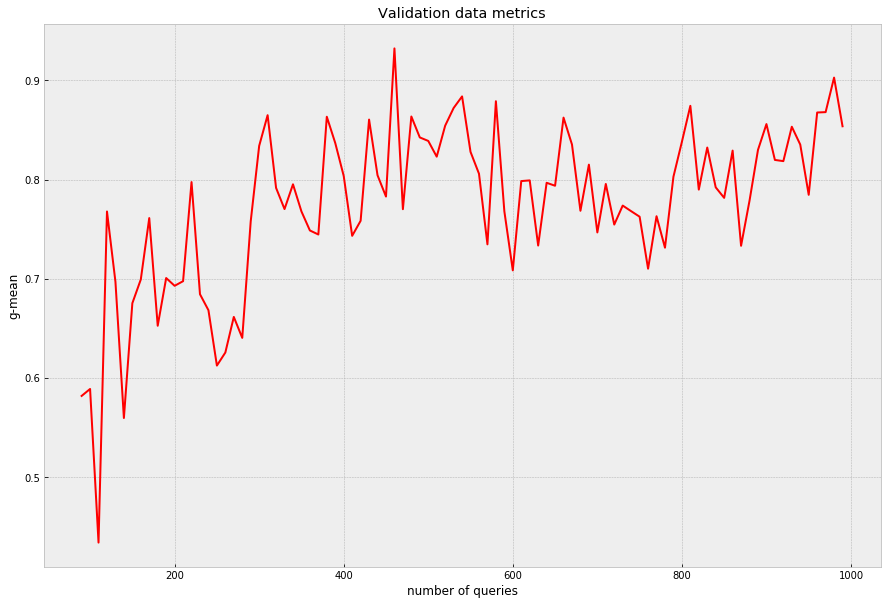

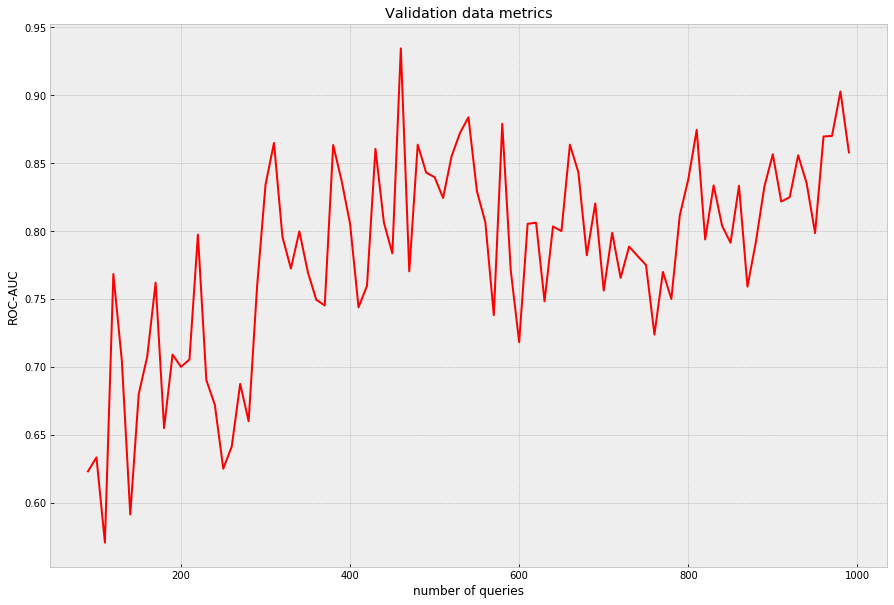

In [61]:
# precision, recall, accuracy, g-mean, ROC-AUC
val_precision, val_recall, val_accuracy, val_gmeans, val_auc = zip(*cal.metrics['valid'])
# make plots
plots.plot_cal_metrics(val_precision, val_recall, val_accuracy, val_gmeans, val_auc, cal.eval_xs['valid'], 'Validation')

As we can see the general trend is increasing towards the right (number of queries) and the noisy nature is because of two reasons, 1) the set is growing with number of queries as per the `pr_rate` configured so it is expected to have high variance but the more the queries the more stable results will be towards right and 2) being the nature of uncertainty and difficulty in classifying the sampled points, as model is continually changing and adjusting its decision boundary.  

##### Unlabeled Evaluation

It is possible to evaluate on unlabeled data in simulation mode because we actually have access to the true labels so model's prediction can be assessed.

In [62]:
# performance on rest of data (unlabeled/not queried)
# note: in real setting this won't be possible to use as quality / performance measure
unlabeled_X, unlabeled_indexes = cal.dataset.get_unlabeled_data()
unlabeled_y = cal.dataset.y_ideal[unlabeled_indexes]

num_unl_pos = sum(unlabeled_y)
num_unl_neg = len(unlabeled_y) - num_unl_pos

print("Number of relevant document in unlabeled set: {}".format(num_unl_pos))
print("Number of irrelevant document in unlabeled set: {}".format(num_unl_neg))

Number of relevant document in unlabeled set: 1509
Number of irrelevant document in unlabeled set: 11731


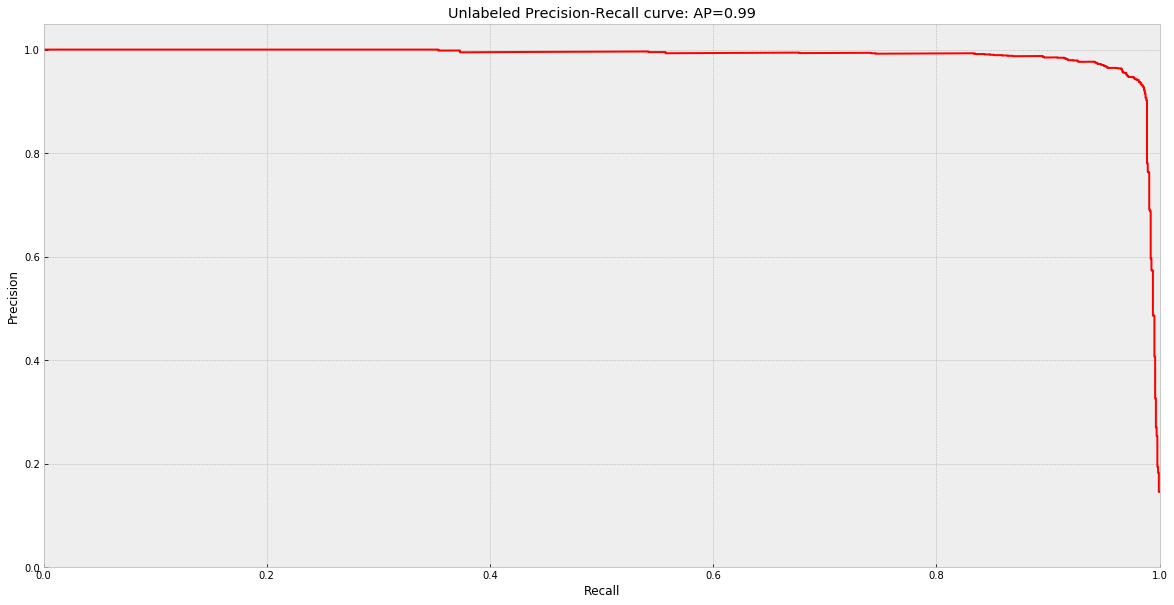

In [63]:
# computes scores
unlabeled_X_scores = cal.model.decision_function(unlabeled_X)
# plot Precision-Recall curve
plots.pr_curve(unlabeled_y, unlabeled_X_scores, 'unlabeled', False)

The curve approximates to ideal PR-curve with an area of ~100%. This due to the fact that the problem at hand is well separable and the points in unlabeled pool are far from uncertain region of decision boundary.

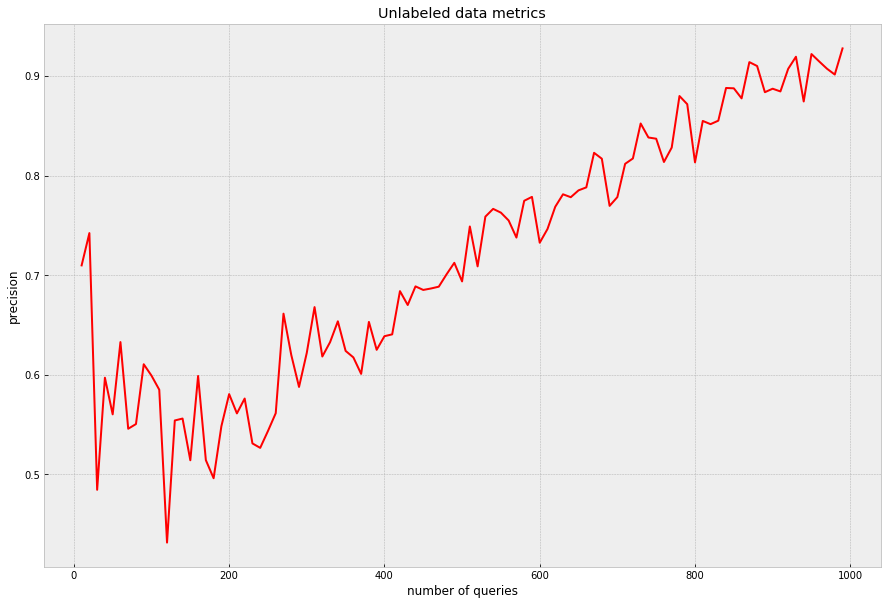

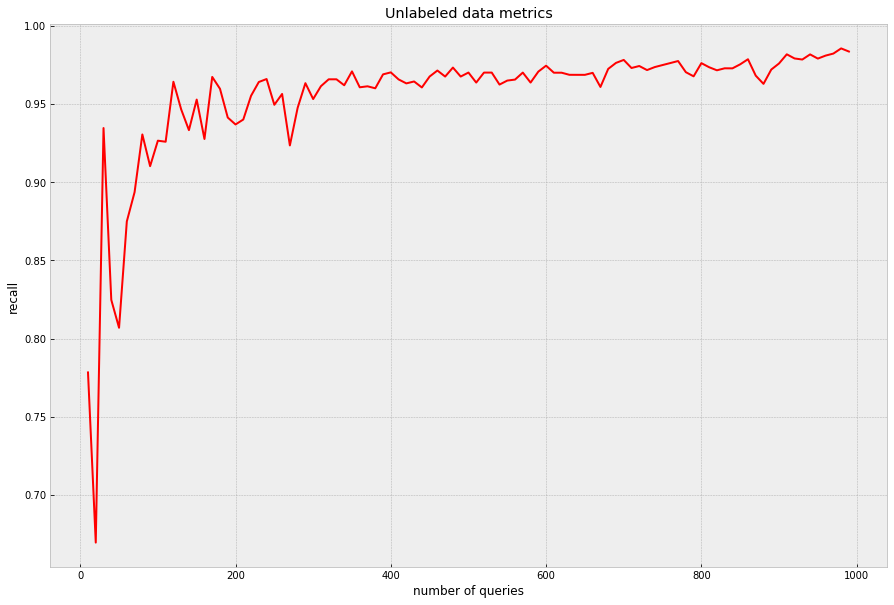

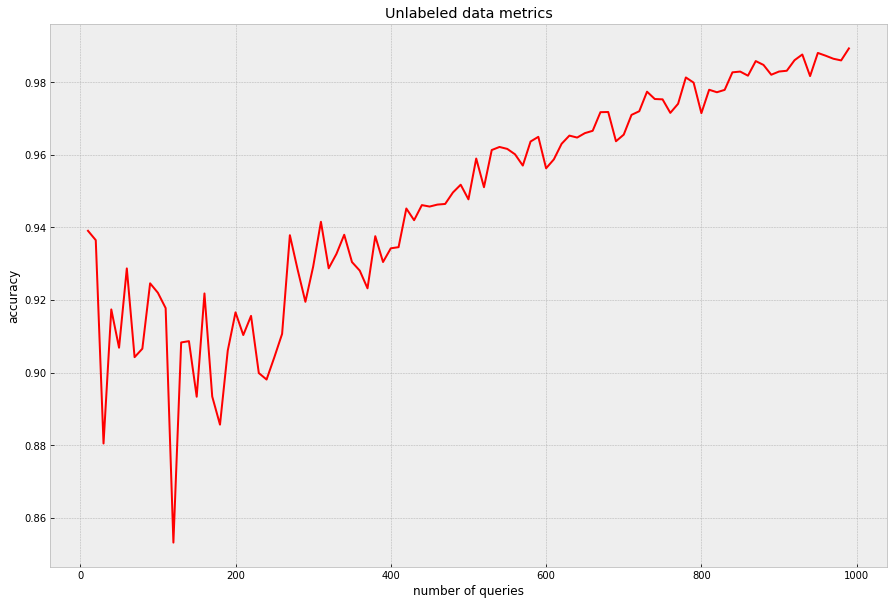

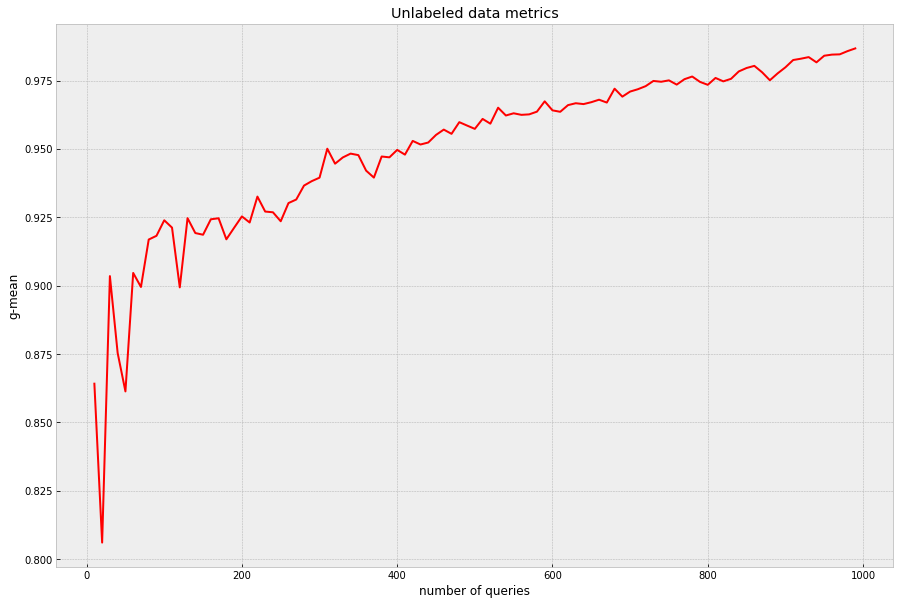

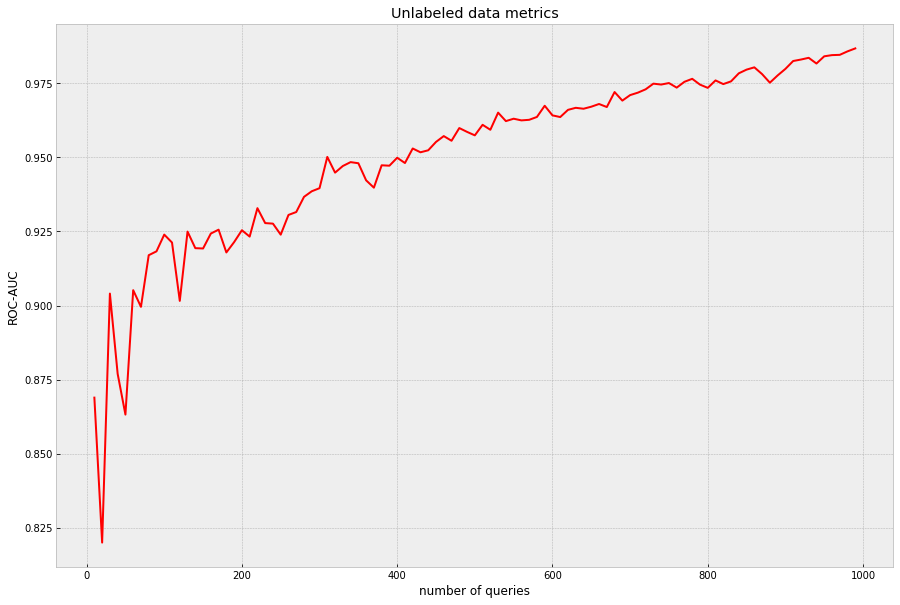

In [64]:
# precision, recall, accuracy, g-mean, ROC-AUC
ul_precision, ul_recall, ul_accuracy, ul_gmeans, ul_auc = zip(*cal.metrics['simulate'])
# make plots
plots.plot_cal_metrics(ul_precision, ul_recall, ul_accuracy, ul_gmeans, ul_auc, cal.eval_xs['simulate'], 'Unlabeled')

All metrics are generally monotonically increasing with number of queries and reach stabalized and saturated state near the end. 

The evaluation on unlabeled set shows that despite having varying performance on validation/test set, the performance on unlabeled set is much stable and reflects model has learned well to classify the data.

In [65]:
# after learning phase has completed, let's look how many relevant documents have we discovered
# how much we are off from our estimated number and relation to actual left-over relevant docs

print("Number of relevant documents found during learning (including seed): {}".format(cal.relevant_found))
print("Estimated number of relevant documents: {}".format(cal.est_relevant))

min_doc_review, max_doc_review = cal.ci
min_doc_review = int(cal.dataset.X.shape[0] * min_doc_review)
max_doc_review = int(cal.dataset.X.shape[0] * max_doc_review)

print("Number of documents to review to cover full range of relevant document: {}-{}".format(
    min_doc_review-cal.relevant_found, max_doc_review-cal.relevant_found))

Number of relevant documents found during learning (including seed): 108
Estimated number of relevant documents: 2270
Number of documents to review to cover full range of relevant document: 1019-3790


## Review Phase

In review phase the unlabeled documents are reviewed till the point that reviewer thinks there are not leftover relevant documents or all previliged documents have been reviewed. To do this, the review happens in _k_ sized batches on list of documents sorted according to their relevancy scores based on model's predictions while monitoring _precision-recall @ k_.  

#### Estimating number of documents to review

The subject is partially covered in section just above and we saw a range of documents to review to make sure that our estimated prevalence's true value lie within the range. Another way to approximate it is with a well known formulae use in predictive coding (Dimm, 2015):

$$n = \frac{\rho N R}{P}$$

Where,

$n$ = number of docs to review

$\rho$ = prevalence

$N$ = number of non-training docs

$R$ = desired recall

$P$ = precision at desired recall

In this setting the reviewer decides a certain recall to achieve (discovering % of total number of relevant documents) and with prevalence range one can convert in to a function of precision. 

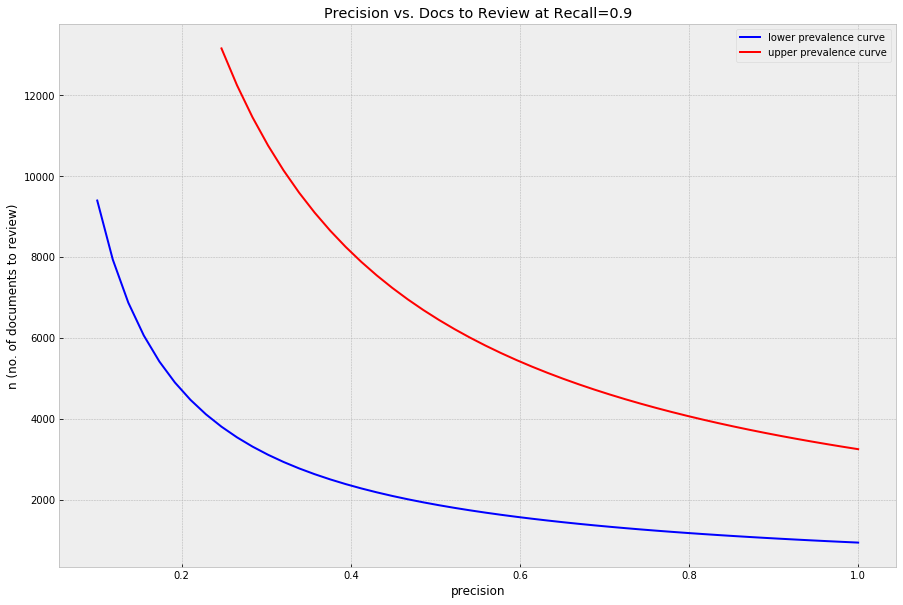

In [66]:
# number of non-training docs
N = cal.dataset.len_unlabeled()
# upper and lower estimates of prevalence
prev_min, prev_max = cal.ci
# desired recall (change as required)
R = 0.90

precision_sweep = np.linspace(0.1, 1.0, 50)

n_min_curve = np.array([prev_min * N * R] * len(precision_sweep))
n_min_curve = n_min_curve / precision_sweep
nmin, nminp = list(), list()
for i, j in zip(n_min_curve, precision_sweep):
    if i < N:
        nmin.append(i)
        nminp.append(j)

n_max_curve = np.array([prev_max * N * R] * len(precision_sweep))
n_max_curve = n_max_curve / precision_sweep
nmax, nmaxp = list(), list()
for i, j in zip(n_max_curve, precision_sweep):
    if i < N:
        nmax.append(i)
        nmaxp.append(j)

plt.figure(figsize=(15, 10))
plt.plot(nminp, nmin, color='blue', label='lower prevalence curve')
plt.plot(nmaxp, nmax, color='red', label='upper prevalence curve')
plt.xlabel('precision')
plt.ylabel('n (no. of documents to review)')
plt.title('Precision vs. Docs to Review at Recall={}'.format(R))
plt.legend()
plt.show()

In [67]:
# let's compare it with previous technique
print("Number of documents to review to cover full range of relevant document with this formula: {}-{}".format(
    int(nmin[-1]), int(nmax[-1])))
print("Number of documents to review to cover full range of relevant document with previous method: {}-{}".format(
    min_doc_review-cal.relevant_found, max_doc_review-cal.relevant_found))

Number of documents to review to cover full range of relevant document with this formula: 939-3248
Number of documents to review to cover full range of relevant document with previous method: 1019-3790


As we can see the two estimates are approximate equal in lower bound with small difference in upper bound. It is to be noted that the method decribed earlier to estimate number of documents is simply based on estimates without any assumption about precision and recall. 

However, the decision to find optimal _n_ is challenging and stopping criteria can be achieved by looking at predictive coding ranked PR-curve @ k.

In [68]:
# number of documents to review, set it to override default behavior
# which reviews #(total estimated relevant - relevant found in CAL)docs
R = None

In [69]:
# review instantiation will immediately (internally) rank the unlabeled
# documents based on distances from decision boundary
review = Review(
    cal.dataset, cal.model, cal.est_prevelance,
    cal.est_relevant, cal.relevant_found,
    num_docs_to_review=R
)

In [70]:
# number of top-k docs to review per batch
K = 10

review.review(K) # prepare batches

#### Precision and Recall at K

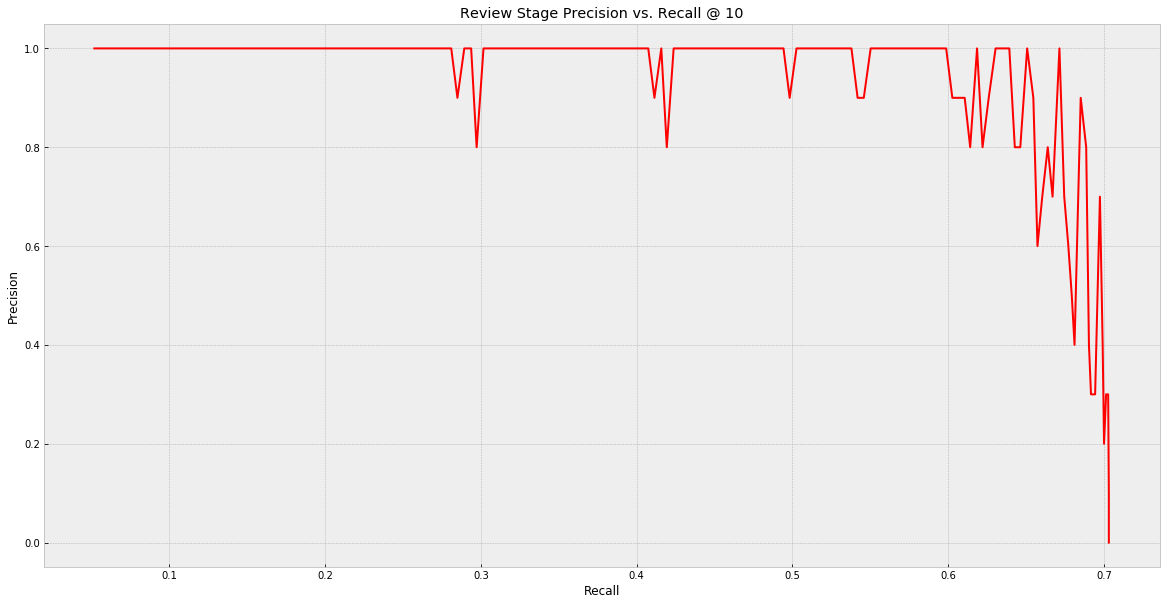

In [71]:
_ = review.pr_at_k() # precision-recall @ K in predictive coding setting

Since this calculation is based on estimated value of recall which is overestimating the number of relevant documents in corpus therefore our recalls flattens to less than 0.6 and precision drops to 0.0 which is indicitive that doing more review will likely result in only irrelevant documents. Depending on data this curve can drastically change but the fact that we are converting a non-ranked distance problem to a ranked list makes precision very high at all recalls as we are highly confident of examples far away from border to be relevant.

#### Document Rank Distribution

Review visualization $-$ project monitoring graph-1 as like Relativity:

"_The Document Rank Distribution is one of the monitoring charts in the Active Learning project homepage. This ranks each document in the model, including manually-selected documents, based on how it relates to the overall project. A relevance rank near zero indicates the model believes the document is more likely coded on the negative review field choice. On the other hand, a rank closer to 100 means the model believes a document is more likely to be coded on the positive review field choice. In the early stages of an Active Learning project, most documents will have a relevance rank score between 40 and 60 until the model begins training._

_The review state of the documents are also overlaid on this distribution. Note that it is possible for a document coded on the positive choice to have a lower relevance ranking; this is because the rank is simply the model's prediction._"

Source: https://help.relativity.com/9.6/Content/Relativity/Active_Learning/Project_Monitoring.htm

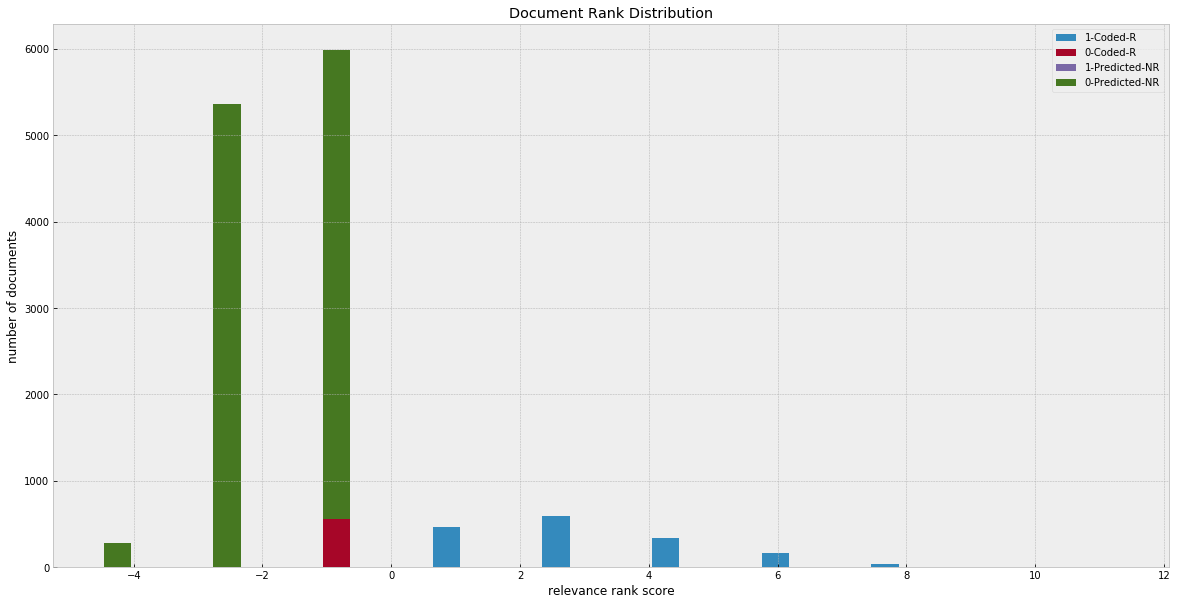

In [72]:
"""
document rank distribution as Relativity (set scale to True to get
like their relevance scale from 0 to 1, which ideally is not good
thing to do with SVM but keep raw dists as -neg ones tell that those
instances are predicted as irrelevant rather than saying 0.2 relevant
further, the magnitude tells how much effort to put in review, the
farther the document is on left side, the higher is their irrelevance)
"""

review.drd(False)

#### Prioritized Review Progress

Review visualization $-$ project monitoring graph-2 as like Relativity:

"_The Prioritized Review Progress chart displays the effectiveness of the prioritized review queue's ability to locate the relevant documents by measuring the relevance rate. More specifically, the relevance rate measures the percentage of documents that were predicted to be relevant that were then confirmed as relevant by reviewers' coding decisions._

_Relevance rate is calculated every 200 documents for frequent feedback. Once 200 documents are coded in prioritized review, relevance rate data appears on the chart._"

Source: https://help.relativity.com/9.6/Content/Relativity/Active_Learning/Project_Monitoring.htm

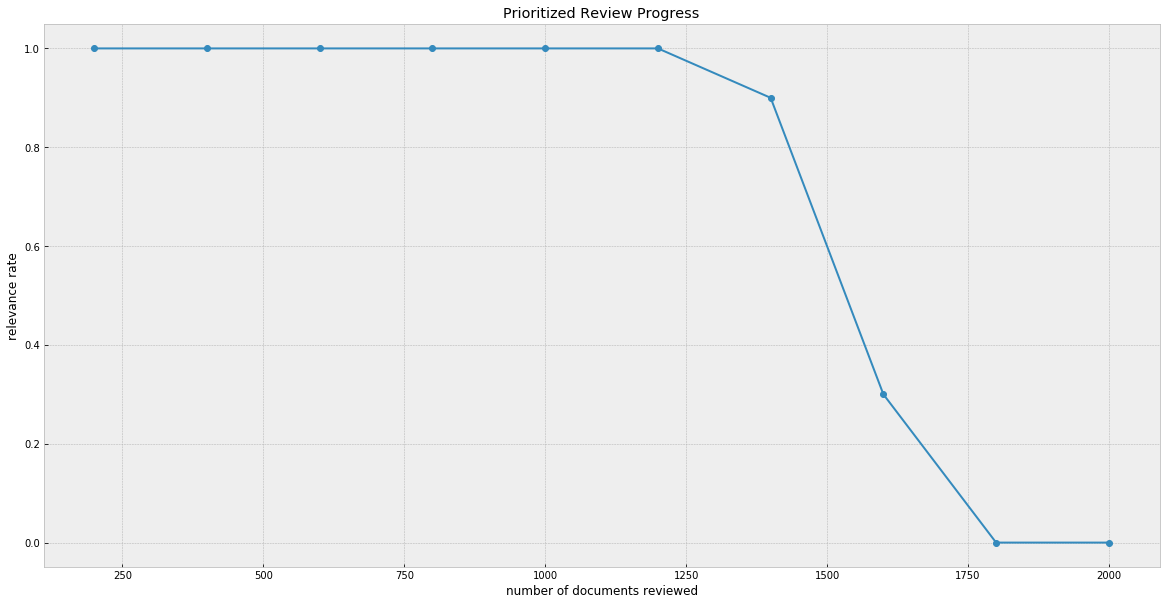

In [73]:
review.prp(200) # prioritized review progress like Relativity

## Test Set Evaluation (Supervised vs. Active)

In [74]:
# report test results
cal_y_test_preds = cal.model.predict(X_test)
cal_results = {
    'accuracy': metrics.accuracy(y_test, cal_y_test_preds),
    'precision': metrics.precision(y_test, cal_y_test_preds),
    'recall': metrics.recall(y_test, cal_y_test_preds),
    'gmeans': metrics.g_means(y_test, cal_y_test_preds),
    'auc': metrics.auc(y_test, cal_y_test_preds),
    'cohen-kappa': metrics.user_machine_agreement(y_test, cal_y_test_preds)
}


print("Test set evaluation")
print("Supervised |    CAL       | Metric")
print("--------------------------------------")

for metric in cal_results.keys():
    print("%0.4f     |    %0.4f    | %s" % (supervised_results[metric], cal_results[metric], metric))

Test set evaluation
Supervised |    CAL       | Metric
--------------------------------------
0.9868     |    0.9769    | gmeans
0.9788     |    0.8538    | precision
0.9952     |    0.9796    | accuracy
0.9762     |    0.9735    | recall
0.9868     |    0.9769    | auc
0.9748     |    0.8983    | cohen-kappa


## Feature Visualizations

One off-the-shelf utility that can be presented to users with BoW features is by visualizaing top-ranked classifier features that influences its decision making. Below we show top-30 positive and negative class features for CAL model. 

### Classifier Top-N Positive & Negative Features

2018-10-14 07:24:21,682 : INFO : loading Dictionary object from features\tfidf_vocab
2018-10-14 07:24:21,703 : INFO : loaded features\tfidf_vocab


Class [+] top-30 features:
7.8611	enron
5.8456	neon
5.6126	actuals
5.5103	august
5.3968	lindy
5.3930	expedia
5.1946	poi
5.1545	netco
5.1465	transportation
5.0060	prc
5.0041	cera
4.8211	dbcaps
4.8200	kaminski
4.7731	password
4.7622	bridgeline
4.7110	marathon
4.6653	vitro
4.5370	congratulations
4.5234	gbp
4.3347	deng
4.2767	membership
4.2681	louise
4.2450	thanks
4.2304	outage
4.2199	dy
4.1574	kevin
4.0909	mwh
4.0621	portal
4.0106	aep
3.9526	gis

Class [-] top-30 features:
-2.8170	http
-2.7989	remove
-2.7022	gold
-2.6606	click
-2.6555	software
-2.5313	free
-2.4859	mobile
-2.3464	account
-2.3210	want
-2.2714	wed
-2.2525	fucking
-2.1587	life
-2.1530	interested
-2.1364	statements
-2.1327	virus
-2.0740	o
-2.0733	site
-2.0577	body
-2.0219	quality
-1.9833	xp
-1.9822	rolex
-1.9798	t
-1.9736	upgrade
-1.9629	info
-1.9355	link
-1.9311	costco
-1.9260	de
-1.8880	read
-1.8680	big
-1.8665	professional



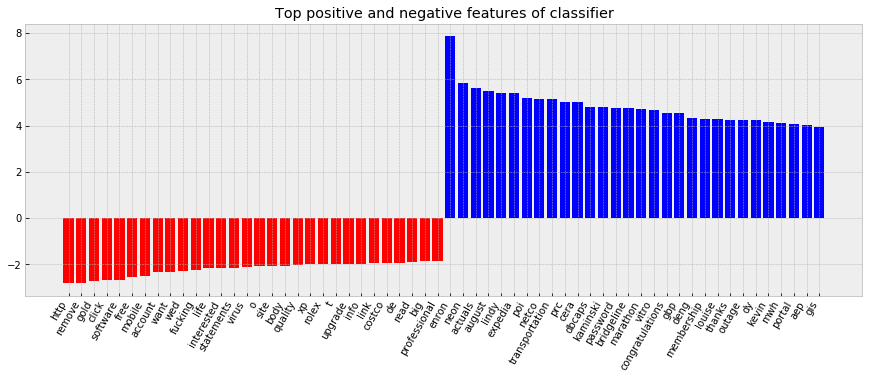

In [75]:
# let's look at top 30 features for both spam and ham classes

# we will need vocab object to get features names
vocab = Dictionary.load(join(FEATURES_DIR, 'tfidf_vocab'))

id2token = {id_:token for token, id_ in vocab.token2id.items() if id_ != -1}

# sanity check
assert len(id2token) == data_X.shape[1]

features_names = [id2token[i] for i in range(len(id2token))]
topfeats = features.clf_topn_coef(cal.model, features_names, 30, True)

### Document Level Feature Visualization

We can extend same idea from classifier to documents level and visualize positive and negative features and their contribution to document's prediction, for this we will randomly choose a positive and negative predicted document and plot their features.

#### Random Positive Sample Features

Class Prediction: 1 | Features Contribution:
0.2843	kaminski
0.1816	volatility
0.1474	values
0.1179	risk
0.0914	wednesday
0.0859	july
0.0567	regards
0.0564	market
0.0551	october
0.0504	notes
0.0464	sure
0.0458	useful
0.0441	fw
0.0373	copy
0.0355	original
0.0335	named
0.0238	sent
0.0202	measuring
0.0160	j
0.0134	action
0.0133	privileged
0.0126	received
0.0116	e
0.0090	impact
0.0082	aol
0.0062	error
0.0049	message
0.0014	send
0.0009	dr
0.0000	vkaminski
0.0000	vic
0.0000	pty
0.0000	postmaster
0.0000	optimal
0.0000	monte
0.0000	modelling
0.0000	jane
0.0000	evaluating
0.0000	embark
0.0000	bhp
0.0000	addressee
-0.0005	able
-0.0025	sydney
-0.0036	attended
-0.0040	disseminate
-0.0041	notified
-0.0050	extreme
-0.0052	reliance
-0.0062	notice
-0.0069	exercise
-0.0081	calculate
-0.0082	information
-0.0125	sections
-0.0128	intended
-0.0131	recipient
-0.0135	australia
-0.0168	g
-0.0182	au
-0.0196	email
-0.0207	carlo
-0.0208	contains
-0.0212	use
-0.0251	look
-0.0263	fax
-0.0270	accurately
-0.0276	rec

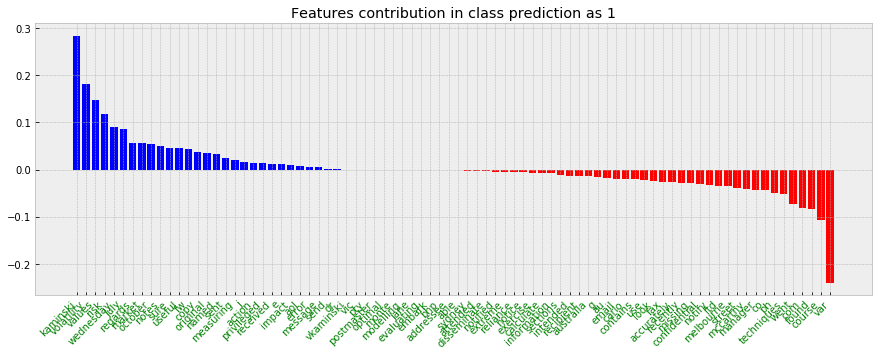

In [76]:
# features of randomly selected positive (ham) document
pos_ind = np.random.choice(np.argwhere(y_test == 1).flatten())
_ = features.features_predictive_contrib(cal.model, X_test[pos_ind, :], np.array(features_names), True)

#### Random Negative Sample Features

Class Prediction: 0 | Features Contribution:
0.2462	christina
0.2204	account
0.2070	rat
0.1838	link
0.1709	site
0.1611	consultant
0.1571	pre
0.1356	secure
0.1184	low
0.1125	t
0.1105	good
0.0877	exclusive
0.0769	visit
0.0753	mo
0.0709	application
0.0639	selected
0.0368	senior
0.0295	new
0.0203	previous
0.0203	program
0.0119	finish
0.0102	afford
0.0102	jump
0.0086	business
0.0058	ge
-0.0000	setup
-0.0000	rtg
-0.0000	ridiculously
-0.0165	offering
-0.0195	join
-0.0252	long
-0.0309	e
-0.0645	day
-0.1102	thank
-0.1699	away
-0.2624	following
-0.4769	phase


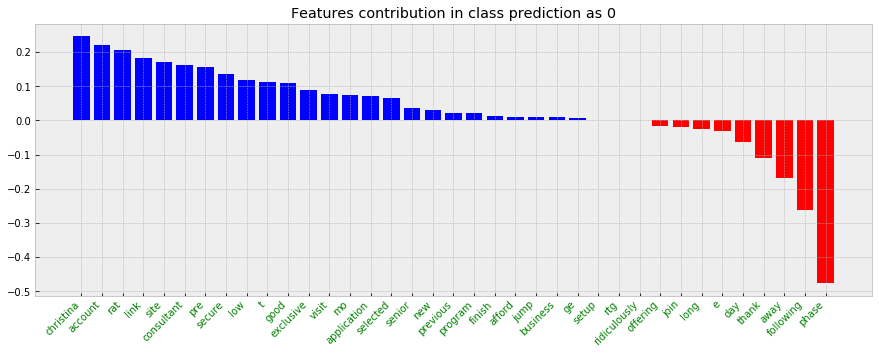

In [77]:
# features of randomly selected negative (spam) document
neg_ind = np.random.choice(np.argwhere(y_test == 0).flatten())
_ = features.features_predictive_contrib(cal.model, X_test[neg_ind, :], np.array(features_names), True)

# Active Learning Algorithms

In this section we will briefly discuss different active learning algorithms and share thoughts on each and implementation choices. Here we aim to give intuition behind algorithms without diving into too much details, for each algorithm we recommend reader to look original papers. 

From our earlier discussion recall that an active learning algorithm aims to achieve better or equal performance as supervised learning with much less training data. Therefore the central theme is **what points to pick?** that we can reduce label complexity. With this understanding in mind, let's look into some of these algorithms.

## Uncertainty Sampling (US)

Uncertainty Sampling (US) is most used AL algorithm both in literature and in practice. As the name suggests, it tries to sample from _uncertain regions_ based and the basic premise is that the learner can avoid querying the instances it is already confident about, and focus its attention instead on the unlabeled instances it finds confusing (Settles, 2012).

<img src="imgs/us-sep-2d.jpg" width="500px">

Figure* above shows a 2D dataset with two classes represented by square and circle shaped datapoints while triangular points are unlabeled. Uncertainty sampling will pick the point closest to margin (line separating two sets of classes) as most informative and uncertain data point and ask for its label.

US has three varitions:

#### Least Confident

In this case the active learner picks the unlabeled instance whose prediction it is least certain about. The notion of least confidence depends on nature of model (e.g. probabilistic models offer scores in terms of probabilities, continuous models offer real valued scores).

#### Smallest Margin

Here we sample the point for which the margin (abs difference) between predicting the example as 0 or 1 is smallest. Its natural extension to multi-class takes top two classes to find the smallest margin. 

#### Entropy

Entropy is a measure of information content from a random variable, it is often thought of as uncertainty measure in machine learning. This naturally applies to US as such that we pick the data point with highest entropy (information content). One way to think about it is that the most confident predictions doesn't add further to model's knowledge about uncertainty as compared to relatively less confident examples.

#### Remarks

Of three methods, entropy is unbiased in its selection as it doesn't favor any particular class while smallest margin attempts to aid model in learning the most discriminative traits among classes and thus favoring applications where the goal is simply to reduce classification error. Least confidence is a middle ground between two methods. Furthermore, smallest margin works only with continuous models while entropy works with only probabilistic models, least confidence work with both. 

#### Implementation

Adopted from libact's [US module](https://libact.readthedocs.io/en/latest/libact.query_strategies.html#libact-query-strategies-uncertainty-sampling-module) with adjustments to support the changes we made in Dataset API. 

#### Paper

D. D. Lewis and J. Catlett. [Heterogeneous uncertainty sampling for supervised learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.78.5749&rep=rep1&type=pdf). In Proceedings of the _International Conference on Machine Learning (ICML)_, pages 148–156. Morgan Kaufmann, 1994.

D. D. Lewis, and W. A. Gale. [A sequential algorithm for training text classifiers](https://arxiv.org/pdf/cmp-lg/9407020.pdf). In _Proceedings of the 17th annual international ACM SIGIR conference on Research and development in information retrieval_, pp. 3-12. Springer-Verlag New York, Inc., 1994.

F. Jing, M. Li, H. Zhang, and B. Zhang. [Entropy-based active learning with support vector machines for content-based image retrieval](https://www.researchgate.net/profile/Bo_Zhang144/publication/4124532_Entropy-based_active_learning_with_support_vector_machines_for_content-based_image_retrieval/links/56a71a4908ae997e22bb2ffb.pdf). In _ICME_, 2004, pp. 85–88.

\* <font size="1"><i>Figure is taken from Ertekin et al., 2007 with some modification</i></font>

## Query by Disagreement (QBD)

In learning theory a model is often called _hypothesis_ that learns from training data and attempts to generalize on unseen data. For any particular model, e.g. Support Vector Machine (SVM), different parameters define a different instance of model and there exists an infinite or countably infinite instantiations of any particular model class that creates a set of hypotheses called _hypothesis space_ $\mathcal{H}$. Given this, there exists a sub-set $\mathcal{V} \subseteq \mathcal{H}$, for which every instance of sub-set perfectly classifies the labeled data i.e. 0 training loss making it _consistent_ with training data. This sub-set $\mathcal{V}$ is called _version space_. Therefore for a particular labeled set $\mathcal{L}$ we have $\mathcal{V}$ as a set of candidate hypothesis to choose from, in light of this an active learning algorithm should sample an instance for which if we obtain the label, the size of the resultant version space $|\mathcal{V}|$ consistent with $\mathcal{L}$ reduces. QBD works on this idea as it sample points from a region where any two hypotheses in version space disagree, such region is called _region of disagreement_ DIS($\mathcal{V}$). 

#### Remarks

As discussed above, its easy to realize that such version spaces will be infinite and pairwise disagreements make it intractable to manage. There has been modifications to this approach in such, that only the most specific and most general subsets (hypothesis extremas) of $\mathcal{V}$ are considered. Another short-coming of QBD is the fact that $\mathcal{V}$ is only defined if underlying learnable function is separable i.e. consistent which doesn't happen to be case in many real-world datasets. Theoretically, QBD is better than US because it attempts to find disagreement among different choices of models and not fitting to only one particular model instantiation.

#### Paper

D. Cohn. [Neural network exploration using optimal experiment design](https://papers.nips.cc/paper/765-neural-network-exploration-using-optimal-experiment-design.pdf). In _Advances in Neural Information Processing Systems (NIPS)_, volume 6, pages 679–686. Morgan Kaufmann, 1994.

S. Hanneke. [Theory of Disagreement-Based Active Learning](http://www.stevehanneke.com/docs/active-survey/active-survey.pdf). In _Foundations and Trends in Machine Learning_, Volume 7 (2-3), pages 131-309, 2014.

O. Bousquet, S. Boucheron, and G. Lugosi. [Introduction to statistical learning theory](http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2819.pdf). In _Advanced lectures on machine learning_, pp. 169-207. Springer, Berlin, Heidelberg, 2004.

V. Vapnik. [_Statistical learning theory_](https://www.wiley.com/en-us/Statistical+Learning+Theory-p-9780471030034). Wiley, 1998.

## Query by Committee (QBC)

QBC builds on ideas from disagreement based AL, it improves the applicability by relaxing $\mathcal{V}$ to only a small set $\mathcal{C}$ (approximating $\mathcal{V}\approx\mathcal{C}$) of hypotheses called _committee_ or _ensemble_. This implies that we want to query instances which are uncertain but in such a way that there is disagreement among the competing hypotheses. To formalize a bit, let $I(Y;\mathcal{C})$ represent mutual information between label and committee $\mathcal{C}$ i.e. the information content gained between a label and set of competing hypothesis. We therefore want to maximize this information measure which can be approximated to (roughly speaking):

$$I \approx entropy(Y) - avg. entropy(Y given \mathcal{V})$$

Where first term informs about label uncertainty and to mazimize $I$ the second term should be smaller. If the choices of hypotheses largely agree on a label, then second term will be very close to first, and the information content is deemed to be low; the more they disagree, the lower the second term is and the higher the overall information content.

The notion of disagreement is measured with _vote-entropy_, which extends entropy from US to incorporate committe votes for a specific data point. A variant of vote-entropy is called _soft vote-entropy_ where instead of counting exact votes, each hypothesis contribution in committee is modeled by their label probabilites. Another measure used extensively is _Kullback-Leibler (KL) divergence_, which measures the difference between two probability distributions. In QBC, it means to measure differences among committee memebers' ouput predictive distributions (posterior label distribution).

#### Remarks

QBC is a great alternative to US sampling and can be seen as more general version of it. The idea to maximize the mutual information between an instance's unknown label and the learning algorithm's unknown hypothesis is a direct improvement on US. It also smoothes out the single hypothesis variance in US. However, the drawback comes from the fact that we need to manage multiple models $-$ typical committee size if 5 to 15 $-$ which presents computational challenges depending on models complexity and training data sizes. Also, the fact that we need make predictions for each committee member on large-pool of unlabeled data and measure pairwise disagreements at each query steps make it further challenging. Though this can be resolved by usage of simpler models or weak learning algorithms. Such ideas have been explored in ensemble setting leading to _query by boosting_ and _query by baggging_ approaches. 

#### Implementation

libact offers [QBC module](https://libact.readthedocs.io/en/latest/libact.query_strategies.html#module-libact.query_strategies.query_by_committee) with `vote-entropy` and `KL-divergence` as disagreement measure and bootstrap aggregation (_bagging_) based ensemble learning. Few changes were made to accomodate our Dataset API changes.

#### Papers

H. S. Seung, M. Opper, and H. Sompolinsky. [Query by committee](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.30.3233&rep=rep1&type=pdf). In _Proceedings of the ACM Workshop on Computational Learning Theory_, pages 287–294. ACM, 1992.

Y. Freund, H. S. Seung, E. Shamir, and N. Tishby. [Selective samping using the query by committee algorithm](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.5262&rep=rep1&type=pdf). _Machine Learning_, 28:133–168, 1997.

N. Abe and H. Mamitsuka. [Query learning strategies using boosting and bagging](http://bic.kyoto-u.ac.jp/pathway/mami/pubs/Files/icml98.pdf). In _Proceedings of the International Conference on Machine Learning (ICML)_, pages 1–9. Morgan Kaufmann, 1998.

## Expected Error Reduction (EER)

In previous methods we have attempted to sample from informative instances or ones that reduce version spaces, none of these approaches directly model the ability to reduce future error. The key intuition behind error reduction is that the current knowledge can be used to avoid future mistakes. However, we don't know future error as we don't have the labels so, expected (or average) error approximates this notion by errors made on unlabeled pool $-$ as it _loosely_ represents test distribution $-$ will be indictive of future error.

To further clear the understanding, let $m$ be our current model and $m_+$ be model after we have added an unlabeled example $x$ to training set $\mathcal{L}$ with hypothetical label $y$. In case of binary classification this implies to reduce 0-1 loss; first we give a hypothetical label 0 to $x$ and add it to train set, train the model to get $m_+$ and count predictions on rest by $m$ and $m_+$ where their predictions disagree, i.e. $y_m \neq y_{m_+}$, we then repeat the same for label 1. The errors for each label are then averaged to get expected error of $x$ and this process is repeated for all $x$ in unlabeled pool $\mathcal{U}$, $x$ with least expected error is then queried for label. 

#### Remarks

The idea of reducing expected error works greatly in favor of generalization to unseen data, however, in most cases, unfortunately, expected error reduction is computationally very expensive. Not only does it require estimating the expected future error over $\mathcal{U}$ for each query, but a new model must be re-trained for every possible labeling of every possible query in the pool. This leads to a drastic increase in computational cost.

To cater some of these issues, simpler models, where incremental/online training is supported and is efficient, should be used like Naive Bayes. Non-parametric models such as Gaussian random fields or nearest neighbors also support efficient incremental training. The computational costs becomes very high for other models and multi-class classification problems. Researchers have resorted to sub-sampling $\mathcal{U}$ or approximate training methods. For much of practical tasks, EER is still difficult to manage and its best advised to use in binary tasks with efficient incremental training models. Besides 0-1 or log-loss, EER can easily be extended to optimize metric of interest such as ROC-AUC, precision, recall etc.

#### Implementation

libact [EER module](https://libact.readthedocs.io/en/latest/libact.query_strategies.multiclass.html#module-libact.query_strategies.multiclass.expected_error_reduction) with `0-1` and `log-loss` support. Few changes were made to accomodate our Dataset API changes.

#### Papers

N. Roy and A. McCallum. [Toward optimal active learning through sampling estimation of error reduction](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.28.9963&rep=rep1&type=pdf). In _Proceedings of the International Conference on Machine Learning (ICML)_, pages 441–448. Morgan Kaufmann, 2001.

Y. Guo and R. Greiner. [Optimistic active learning using mutual information](https://pdfs.semanticscholar.org/da1b/74b9c085cf10c1433d09e9c02e178584b34f.pdf). In _Proceedings of International Joint Conference on Artificial Intelligence (IJCAI)_, pages 823–829. AAAI Press, 2007.

## Variance Reduction (VR)

As we saw for EER, the computations become exhaustive and we have to rely on approximate methods. It is quite common in machine learning that generalization error can be reduced indirectly by reducing the variance. A good thing about reducing variance is that often we have closed-form solutions, which at least allow us to take advantage of exact methods. To represent labels variance information with model parameters a statistical measure called _Fisher information_ (FI) is used. One key fact about FI is that its inverse sets lower bound on model's paramaters variance, known as Cramér-Rao inequality. Based on this, the goal here is to pick data point that maximizes FI or minimizes its inverse. The size of FI matrix depends on model parameters, so e.g. a `K`-params sized model has FI of size `K x K`. Statistics literature in _optimal experiments design_ covers in detail the optimization of FI directly by working on eigenvalues or indirectly through its inverse's trace or detereminents therefore we will avoid going in too many details here.

#### Remarks

In much of literature variance reduction has been used for regression problems but it can be applied to classification tasks as well. One key challenge for its computational efficiency is the inverse of FI, which for models with large number of parameters become intractable. Even with most improved computations the resultant methods are still much slower than simpler techniques like US.

#### Implementation

Due to inverse computations libact relies on external C code for efficiency and therefore its ([VR module](https://libact.readthedocs.io/en/latest/libact.query_strategies.html#module-libact.query_strategies.variance_reduction)) compilation fails on Windows. It is for this reason that this method hasn't been ported.

#### Papers

D. MacKay. [Information-based objective functions for active data selection](https://www.semanticscholar.org/paper/Information-Based-Objective-Functions-for-Active-MacKay/2046412fecff64e095cc5190b69172055afd2094). Neural Computation, 4(4):590–604, 1992.

K. Chaloner and I. Verdinelli. [Bayesian experimental design: A review](http://homepage.divms.uiowa.edu/~gwoodwor/AdvancedDesign/Chaloner%20Verdinelli.pdf). _Statistical Science_, 10(3): 237–304, 1995.

T. M. Cover and J.A. Thomas. [_Elements of Information Theory_](https://www.amazon.com/Elements-Information-Theory-Telecommunications-Processing/dp/0471241954). Wiley, 2006.

## Density Weighted Uncertainty Sampling (DWUS)

The techniques we have discussed so far either cater for _informativeness_, _version space_ or _generalization error_ but doesn't take into account structure of data i.e. _representativeness_. In what follows we will discuss a number of approaches that alleviate this short-coming, starting with DWUS. This method works by first clustering the dataset with K-Means or K-Mediod to discover cluster centroids, once there, it then estimate data density by a mixture of Gaussians with obtained centroids and Expectation-Maximization (EM) training. Having each point's density estimated, it is then used as weighted combination to query instance that minimizes the expected error. To avoid intractable EER like computations, it builds a noisy density weighted logistic regression model to estimate label posterior using cluster centroids. One key intuition that makes this algorithm possible is the fact that if a cluster center is given then output label $y$ is independent of data points $x$ in the cluster since every point in a cluster share same label.

#### Remarks

This was a notable work in active learning as it proposed a formal model for incorporation clustering into active learning. Prior to this there were two other notable works that explored the idea of trade-off between uncertainty and data density. The motivation behind such methods is that sampling around boundary is not good enough but sampling around boundary from _denser_ regions adds a notion of representativeness to informativeness and doesn't ignore data distribution like US.

There is no real bottleneck in this approach but results show that in start DWUS samples from highly dense regions near decision boundary which reduces error quickly, however, after rapid initial gains, DWUS exhibits very slow additional learning where, in comparison, US outperforms it in later phases only at cost of slow learning in the start. Intuitively, in start, DWUS can pick high density points which are lower down in the US ranking but have a high absolute uncertainty score. Later, points with high absolute uncertainty are no longer in dense regions. As a result, DWUS picks points that have moderate density but low uncertainty which does not have a large effect on error rate reduction.

#### Implementation 

libact has DWUS module with support for `DWUS logistic regression`. Few changes were made to accomodate our Dataset API changes.

#### Papers

H. T. Nguyen and A. Smeulders. [Active learning using pre-clustering](https://ivi.fnwi.uva.nl/isis/publications/2004/NguyenICML2004/NguyenICML2004.pdf). In _Proceedings of the International Conference on Machine Learning (ICML)_, pages 79–86. ACM, 2004.

A. McCallum and K.Nigam. [Employing EM in pool-based active learning for text classification](http://www.kamalnigam.com/papers/emactive-icml98.pdf). In _Proceedings of the International Conference on Machine Learning (ICML)_, pages 359–367. Morgan Kaufmann, 1998.

Z. Xu, K. Yu, V. Tresp, X. Xu and J. Wang. [Representative sampling for text classification using support vector machines](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.473.7378&rep=rep1&type=pdf). In _European Conference on Information Retrieval_, pp. 393-407. Springer, Berlin, Heidelberg, 2003.

## Dual Strategy for Active Learning (DUAL)

DUAL improves on DWUS by mixing US with DWUS. It effectively uses DUAL for early phase learning but switches to DUAL+US for later stage when DWUS starts underperforming. The switch happens at DWUS and US (approximate) cross over, the point where two error rates crosses such that after this point DWUS is not improving significantly. Such problems, where we have alternative choices (DWUS and US) and each choice's properties are only partially known (DWUS and US performance) which become better understood as time passes (US improves over DWUS), are called multi-armed bandits. The multi-armed bandit problem attempts to acquire new knowledge (called "exploration") and optimize their decisions based on existing knowledge (called "exploitation"). The agent attempts to balance these competing tasks in order to maximize their total value over the period of time considered. DUAL solves this by querying the point that minimizes the expected error of DWUS and US mixture.

#### Remarks

While DUAL improves DWUS performance, it significantly reduces the efficiency gains obtained from clustering (label propagation in a cluster and indepdence from $x$) due to model re-training and error computations as like in EER, after cross over. The work, however, opened the door for further exploring mixture of query strategies in multi-armned bandit setting.

#### Paper

P. Donmez, G. C. Jaime, and N. B. Paul. [Dual strategy active learning](http://www.cs.cmu.edu/~pbennett/papers/ECML07Dual.pdf). In _European Conference on Machine Learning_, pp. 116-127. Springer, Berlin, Heidelberg, 2007.

## Querying Informative and Representative Examples (QUIRE)

QUIRE is similar to previous approaches (weighting uncertainty by density information) but offers a much more formal framework to solve the problem instead of heuristics based, which often yield sub-optimal results. Figure below illustrates this:

<img src="imgs/quire.jpg" width="900px">

(a) shows optimal boundary in a supervised setting while (b), (c) and (d) shows application of US, DWUS and QUIRE respectively after querying 15 data points*.

#### Remarks

QUIRE is based on the min-max view of active learning, which provides a systematic way for measuring and combining the informativeness and the representativeness compared to its predecessors. Data representation is captured in terms of kernel similarity matrix which, under min-max view and regularized learning framework, can be reduced to closed form solution. The authors simplfy by using least squares as loss function. Empirical results shows significant performance compared to other approaches (including DWUS, US). QUIRE is restricted to binary classification but the fact that there is no learning involved during querying (due to their derived closed form solution to optimization problem in min-max), makes it an attractive method (author also proposes efficient way of computing the solution). However, the major problem in this approach is the pre-computation of kernel similarity matrix $K$ which scales to $O(n^2)$, size of the data (n). One possible solution could be to use kernel approximation methods (such a Nystroem) but it remains to be explored.

#### Implementation

libact provides [QUIRE](https://libact.readthedocs.io/en/latest/libact.query_strategies.html#module-libact.query_strategies.quire) implementation.

#### Papers

S.J. Huang, R. Jin, and Z.H. Zhou. [Active learning by querying informative and representative examples](https://papers.nips.cc/paper/4176-active-learning-by-querying-informative-and-representative-examples.pdf). In _Advances in neural information processing systems_, pp. 892-900. 2010.

S. C. H. Hoi, R. Jin, J. Zhu, and M. R. Lyu. [Semi-supervised svm batch mode active learning for image retrieval](http://mplab.ucsd.edu/wp-content/uploads/CVPR2008/Conference/data/papers/010.pdf). In _Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition_, 2008.

\* <font size="1"><i>Figure is taken from Huang et al., 2010</i></font>

## Hierarchical Sampling for Active Learning (HSAL)

In prior clustering techniques we saw a need of apriori knowledge about clustering, e.g., number of clusters in DWUS/DUAL, similarity function (kernel) in QUIRE, but such clusters may not correspond to the hidden class labels after all. These assumptions can be relaxed in a way that cluster structure is exploited with labels available so far. As names suggests, HSAL employs _Hierarchical Clustering_ to avoid making hard clustering but still maintain a structural hierarchy and as active learning progress the algorithm focuses on impure clusters. Figure* below shows an iteration of HSAL:

<img src="imgs/hsal.jpg" width="700px">

#### Remarks

HSAL is one of the most intuitive and flexible approach of all. Given there exists an underlying hierarchical structure in data, HSAL can exploit it to greater extent, which otherwise is not possible for methods relying on data separability and linear models. There is one step, during label query, in HSAL that samples a cluster node in the hierarchy, this sampling can be performed intelligently or with another active sampling technique; if one opts for former, then there is no additional model or learning involved making it model agnostic. A good hierarchical clustering is key to HSAL performance and if there is no structural clustering inherent to data then its performance drops worst to random sampling. Dense features, e.g., word embeddings, induces such hirerachies in data which makes them good features for use with HSAL. On the other hand, tf-idf or other BoW features are worst to use with HSAL, not only because there remains no structure but also due to the fact that high-dimensionality doesn't go well with hirerachical clustering algorithms, which in itself are computationally challenging.


#### Implementation

libact has [HSAL](https://libact.readthedocs.io/en/latest/libact.query_strategies.multiclass.html#module-libact.query_strategies.multiclass.hierarchical_sampling) implementation with input a hirarchical clustered data. The challenge in HSAL is the pre-clustering of data; sklearn's Aggolomerative Clustering is not scalable, we therefore recommend using hierarchical version of DBSCAN offered by [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/index.html). It also support [predictive clustering](https://hdbscan.readthedocs.io/en/latest/prediction_tutorial.html) where one can cluster a sub-set of data (to avoid computation issues) and then treat as classifier to assign clusters to rest of data. HDBSCAN offers a benchmarks [page](https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html), showing comparisons of various clustering packages in python.

#### Papers

S. Dasgupta and D. J. Hsu. [Hierarchical sampling for active learning](http://www.cs.columbia.edu/~djhsu/papers/hier.pdf). In _Proceedings of the International Conference on Machine Learning (ICML)_, pages 208–215. ACM, 2008.

S. Dasgupta, and J. Langford. [A tutorial on active learning](http://hunch.net/~active_learning/active_learning_icml09.pdf). In _International conference on machine learning_. 2009.

\* <font size="1"><i>Figure is taken from Dasgupta and Langford, 2009</i></font>

## Active Learning by Learning (ALBL)

Recall DUAL $-$ a mixture of DWUS and US in multi-armed bandit setting $-$ ALBL follows similar line of work but provides a more generic and thus, novel framework that allows mixture of any number of query strategies in multi-armed bandit setting. The approach solves the task of choosing from a candidate set of queries adaptively based on their estimated contributions to the learning performance on a given data set. The multi-armend bandit method used by the authors is _Exp4.P_ with slight modification, which in itself is an improved version of _Exp4_. ALBL proposes a novel unbiased test estimator as reward function, to measure arms contibutions, called _Importance-Weighted-Accuracy_ (IWA). IWA is closely related to another method proposed for stream-based AL called _Importance-Weighted-Active-Learning_ (IWAL). 

#### Remarks

ALBL provides a generic framework to employ multiple query strategies thereby allowing it to make best use of other strategies. Often in practice, it is difficult to guess, off-the-shelf, which strategy will work best for the problem at hand or is it even solvable by a single strategy. ALBL alleviates this limitation and makes itself a very practical tool to use. IWA is an unbiased estimator of accuracy so it can also be used as a measure of performance instead of building test sets. Experiments show superior performance on varying tasks and often state-of-the-art. The adaptive nature of algorithm, i.e., taking query strategies contributions at each time step, with probabilistic model makes it unbiased in its selection of queries as well. With some abuse of terminology, we think of it as _ensemble of queries_. Lastly, there is no apparent drawback of this approach except the fact that depending on queries and model combinations, managing large number of queries combinations might become computationally prohibitive.

#### Implementation

ALBL was proposed by libact authors and therefore it includes [ALBL](https://libact.readthedocs.io/en/latest/libact.query_strategies.html#module-libact.query_strategies.active_learning_by_learning) implementation.

#### Papers

W.N. Hsu, and H.T. Lin. [Active Learning by Learning](http://www.aaai.org/ocs/index.php/AAAI/AAAI15/paper/download/9636/9924). In _AAAI_, pp. 2659-2665. 2015.

P. Auer, N. Cesa-Bianchi, Y. Freund, and R.E. Schapire. [The nonstochastic multiarmed bandit problem](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.21.8735&rep=rep1&type=pdf). _SIAM journal on computing_ 32, no. 1 (2002): 48-77.

A. Beygelzimer, J. Langford, L. Li, L. Reyzin, and R.E. Schapire. [Contextual bandit algorithms with supervised learning guarantees](http://www.jmlr.org/proceedings/papers/v15/beygelzimer11a/beygelzimer11a.pdf). In _Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics_, pp. 19-26. 2011.

A. Beygelzimer, S. Dasgupta, and J. Langford. [Importance weighted active learning](https://arxiv.org/pdf/0812.4952). In _Proceedings of the 26th annual international conference on machine learning_, pp. 49-56. ACM, 2009.

## Cost-Sensitive Active Learning

So far the algorithms that we have discussed ignore real world costs such as time, labeling costs and possibly other economic factors. Learning algorithms that take into account such costs falls under _cost-sensitive learning_. These costs are generally represented in the form of confusion matrix, where we have pre-identified costs of false positive and false negative called _misclassification error costs_. These ideas have been extended for active learning as well, commonly reffered as _cost-sensitive active learning_. We will not go into details of such algorithms (mainly because obtaining such real-world pre-set or varying costs are hard to determine and involves many factors) but point to two algorithms that are readily available for experiments in implementation section for multi-class case.

#### Implementation

Vowpal Wabbit implements a cost-sensitive active learning algorithm called _Cost Overlapped Active Learning_ (COAL), please refer to slides [here](https://github.com/JohnLangford/vowpal_wabbit/wiki/cs_active.pdf) or original paper for detailed understanding. A sample command line usage with `vw` would look like:

`./vw -cs_active 3 -d ../test/train-sets/cs test -cost_max 2 -mellowness 0.01 -simulation -adax`

libact implements their novel approach called [_Active Learning with Cost-Embedding_ (ALCE)](https://libact.readthedocs.io/en/latest/libact.query_strategies.multiclass.html#module-libact.query_strategies.multiclass.active_learning_with_cost_embedding). ALCE implements cost-sensitive multi-class classification (CSMCC) by first embedding cost matrix into a hidden space such that cost ordering is preserved with Non-metric multidiemsnional scaling (NMDS is a non-linear dimensionality reduction technique that preserve distances orders rather than distances themselves) mapped as distances (larger distances correponds to higher costs), on which a classifier is learned for labeled pool (prediction is made using nearest neighbor). With cost embedding (CE), it is then natural to think of distance (measure of cost) as a measure of uncertainity thus making uncertainity sampling possible for CSMCC.

#### Papers

A. Krishnamurthy, A. Agarwal, T. K. Huang, H. Daume III, and J. Langford. [Active learning for cost-sensitive classification](https://arxiv.org/pdf/1703.01014.pdf). _arXiv preprint arXiv:1703.01014_ (2017).

K. H. Huang, and H. T. Lin. [A novel uncertainty sampling algorithm for cost-sensitive multiclass active learning](https://www.csie.ntu.edu.tw/~htlin/paper/doc/icdm16alce.pdf). In _Data Mining (ICDM), 2016 IEEE 16th International Conference on_, pp. 925-930. IEEE, 2016.

C. Elkan. [The foundations of cost-sensitive learning](https://www.researchgate.net/profile/Charles_Elkan/publication/2365611_The_Foundations_of_Cost-Sensitive_Learning/links/02bfe513e192c02262000000/The-Foundations-of-Cost-Sensitive-Learning.pdf). In _International joint conference on artificial intelligence_, vol. 17, no. 1, pp. 973-978. Lawrence Erlbaum Associates Ltd, 2001.

## Further Algorithms


**_Tandem Learning_** $-$ Here features importance is collected with human interaction and given added weight (importance). Note, the importance is not directly mapped to classes.

H. Raghavan, O. Madani, and R. Jones. [Active learning with feedback on both features and instances](http://www.jmlr.org/papers/volume7/raghavan06a/raghavan06a.pdf). _Journal of Machine Learning Research_, 7:1655–1686, 2006.


**_Active Dual Supervision_** $-$ Active learning by labeling features, here user can label features that are good indicator of certain class(es).

G. Druck, B. Settles, and A. McCallum. [Active learning by labeling features](https://aclanthology.info/pdf/D/D09/D09-1009.pdf). In _Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP)_, pages 81–90. ACL, 2009.

B. Settles. [Closing the loop: Fast, interactive semi-supervised annotation with queries on features and instances](http://www.aclweb.org/anthology/D11-1136). In _Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP)_, pages 1467–1478. ACL, 2011.

J. Attenberg, P. Melville, and F. Provost. [A unified approach to active dual supervision for labeling features and examples](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.366.2280&rep=rep1&type=pdf). In _Proceedings of the European Conference on Machine Learning and Principles and Practice of Knowledge Discovery in Databases (ECML PKDD)_, pages 40–55. Springer, 2010.


**_Multiple-Instance Active Learning_** $-$ This approach relaxes the fine-tuned feature labeling to instances (made of features) labeling. e.g. instead of labeling word features it might be better to label paragraphs of document to reflect the importance for classification to a specific class.

B. Settles, M. Craven, and S. Ray. [Multiple-instance active learning](http://papers.nips.cc/paper/3252-multiple-instance-active-learning.pdf). In _Advances in Neural Information Processing Systems (NIPS)_, volume 20, pages 1289–1296. MIT Press, 2008b.


**_Imbalanced Active Learning_** $-$ This approach proposes an efficient sampling around the border technique which helps with imbalance problem. Moreover, an early stopping criterion is described for efficient SVM, which happens when support vectors saturate.

S. Ertekin, J. Huang, L. Bottou, and L. Giles. [Learning on the border: active learning in imbalanced data classification](https://clgiles.ist.psu.edu/pubs/CIKM-2007-learning-border.pdf). In _Proceedings of the sixteenth ACM conference on Conference on information and knowledge management_, pp. 127-136. ACM, 2007.


**_Multi-label Active Learning_** $-$ Active learning in multi-label classification setting.

X. Li, and Y. Guo. [Active Learning with Multi-Label SVM Classification](http://www.aaai.org/ocs/index.php/IJCAI/IJCAI13/paper/download/6509/6922). In _IJCAI_, pp. 1479-1485. 2013.

K. Brinker. [On active learning in multi-label classification](https://link.springer.com/chapter/10.1007/3-540-31314-1_24). In _From Data and Information Analysis to Knowledge Engineering_, pp. 206-213. Springer, Berlin, Heidelberg, 2006.

B. Yang, J. T. Sun, T. Wang, and Z. Chen. [Effective multi-label active learning for text classification](https://sites.google.com/site/bishanyang/Home/fp763-yang.pdf). In _Proceedings of the 15th ACM SIGKDD international conference on Knowledge discovery and data mining_, pp. 917-926. ACM, 2009.

C. W. Hung, and H. T. Lin. [Multi-label active learning with auxiliary learner](http://www.jmlr.org/proceedings/papers/v20/hung11/hung11.pdf). In _Asian conference on machine learning_, pp. 315-332. 2011.

libact provides implementation of above approaches in its [multi-label module](https://libact.readthedocs.io/en/latest/libact.query_strategies.multilabel.html).


**_Agnostic Active Learning_** $-$ In active learning theory the major research theme is to investigate the bounds on label complexity and ask question: whether AL has higher label efficiency than supervised setting. These line of works builds on the ideas of QBD, where we reduce version space by disagreement among hypotheses. However, QBD, and its variant QBC, assume version space which is only possible in _realizable_ (when data is linearly separable then there exists an optimal hyperplane) case. The concept of version space doesn't work for noisy labels (where data can not be linearly separated) called _agnostic_ case. Several algorithms have been proposed to work for agnostic case, notably, _Active-Agnostic_ ($A^{2}$), _Importance Weighted Active Learning_ (IWAL) and _Margin based Active Learning_ (MBL). However, these approaches still are computationally intractable due to management of hypthesis space. A recent work called _Agnostic Active Learning without Constraints_ (builds on IWAL) alleviates this, with provable guarantees on label complexity, and makes it implementable. This is, in fact, the [main active learning algorithm in Vowpal Wabbit](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Command-line-arguments#active-learning-options). 

Margin based active learning (MBL) is also promising work (it should not be confused with US-margin setting), the main idea is that the region of disagreement or uncertainty of linear classifier lies within a band (margin) which adaptively shrinks with queries as models effectively becomes better in each iteration. A [recent work](https://youtu.be/Mm001geiHxw?list=PLbbCsk7MUIGefmbBq_-CPumE2u1WVH-r6), extending MBL, makes it computationally efficient, noise tolerant, and with strong label efficiency guarantees by realizing margins on hypothesis (boundary) as well. This concept of margins around boundary or hypothesis class is called _localization_. This approach can directly be seen as many fold improvement on uncertainty sampling. 

For breif understanding of this direction of AL, look [here](http://www.cs.cmu.edu/~ninamf/papers/al-survey-enc-algos.pdf).

M. F. Balcan, A. Beygelzimer, and J. Langford. [Agnostic active learning](http://www.cs.cmu.edu/~ninamf/papers/a2.pdf). In _Proceedings of the International Conference on Machine Learning (ICML)_, pages 65–72. ACM, 2006.

M. F. Balcan, A. Broder, and T. Zhang. [Margin based active learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.122.3394&rep=rep1&type=pdf). In _Proceedings of the Conference on Learning Theory (COLT)_, pages 35–50. Springer, 2007.

A. Beygelzimer, S. Dasgupta, and J. Langford. [Importance weighted active learning](https://arxiv.org/pdf/0812.4952). In _Proceedings of the 26th annual international conference on machine learning_, pp. 49-56. ACM, 2009.


A. Beygelzimer, D. J. Hsu, J. Langford, and T. Zhang. [Agnostic active learning without constraints](https://papers.nips.cc/paper/4014-agnostic-active-learning-without-constraints.pdf). In _Advances in Neural Information Processing Systems_, pp. 199-207. 2010.

## Comparison of Commonly used Algorithms

<img src="imgs/qs-comparison.jpg" width="800px">

\* <font size="1"><i>The table above is taken from Settles, 2012</i></font>

## People

- [Alekh Agarwal](http://alekhagarwal.net/)

- [Alina Beygelzimer](http://hunch.net/~beygel/)

- [Andrew McCallum](https://people.cs.umass.edu/~mccallum/)

- [Burr Settles](http://burrsettles.com/)

- [Daniel Joseph Hsu](http://www.cs.columbia.edu/~djhsu/)

- [Foster Provost](http://people.stern.nyu.edu/fprovost/)

- [Hsuan-Tien Lin](https://www.csie.ntu.edu.tw/~htlin/)

- [John Langford](http://hunch.net/~jl/)

- [Maria-Florina Balcan](http://www.cs.cmu.edu/~ninamf/)

- [Pinar Donmez](http://www.cs.cmu.edu/~pinard/)

- [Sanjoy Dasgupta](http://cseweb.ucsd.edu/~dasgupta/)

- [Sheng-Jun Huang](http://parnec.nuaa.edu.cn/huangsj/)

- [Steve Hanneke](http://www.stevehanneke.com/)

- [Şeyda Ertekin](http://web.mit.edu/seyda/www/index.html)

- [Tong Zhang](http://tongzhang-ml.org/index.html)

## Additional Section

#### Low-dimensional Unbalanced Density Sampling (Cluster Sampling)

We skipped _cluster sampling_ as part of the core demo but here we will present it as an alternative to random sampling for collecting the seed data. One key assumption we make here is that there exists an extreme to moderate _imbalance_ between relevant and irrelevant documents i.e. low prevalence values ranging from less than 1% upto 20% (often real-world cases have values less than 10%). The intuition here is that if we draw random samples from this data then we can expect sample distribution to be representative of population preserving true prevalence with some confidence. If we draw `r` sized random batches from the data then we have a set of candidate random sets that all follows the original heuristic that, prevalence is low so we can expect less number of relevant documents than irrelevant per batch. In each such batch, if a two clusters clustering is applied then, without loss of generality, the cluster with lower number of data points will likely to have higher _# of relevant documents to cluster size_ ratio than the larger cluster. The gains are two fold, 1) the sample space to look for relevant documents has reduced (first due to `r` sized batches which avoids looking at full dataset and second due to narrower scope with small cluster) and 2) the _success rate_ or _hit rate_ to find relevant documents in this clustered pool will be much higher than looking at original batch. This technique is further extended by re-applying the same idea to smaller cluster we obtained. Another application of two clusters clustering to this cluster further reduces the number of documents to review while purifying the cluster from irrelvant documents and enhacing the hit rate. After the whole process repeats for all the batches, we end up with a pool of documents (second smaller cluster from each round) which either can be reviewed as a whole for seed relevance or as pool.

#### Implementation

The approach is fully data and heuristics driven. It exploits data imbalance as prior knowledge to enhance the chance of finding relevant documents than random sampling. The approach is features sensitive and we used vanilla word2vec with word averaging to represent documents, such representation is fair and doesn't induce a bias for relevant documents while still being computationally friendly for fast and repeated clustering. A detail we skimmed in discussion was the type of clustering in first and second stage. The application of first clustering is optional and be turned off, it is agglomerative clustering (AGGC) with cosine distance, average linkage and with number of clusters as 2. AGGC can be seen as focusing on local structure and therefore, ideally, bringing similar relevant documents closer and aggregating them to form a more purified cluster which would otherwise will be hard to uncover for K-Means like approach. Once AGGC is applied, K-Means is applied on smaller cluster which simply finds a separation between the relevant and irrelevant documents. K-Means will be applied directly if AGGC is turned off but its highly recommended to apply two staged clustering, not only it improves the quality but significantly reduces the number of documents to review. Further, we apply randomized PCA with random number of components to reduce if features dimension is higher than 100. This is merely applied as preprocessing step for clustering to stay computationally efficient. 

#### Remarks

This approach significantly boosts the chance of finding relevant documents and its highly biased therefore, it should never be used to make an estimate for prevalence or number of total relevant documents in data. We only recommend its application for the _only_ purpose of finding relevant documents at high success rates which is benficial from economical point of view as well than random sampling, which can become very expensive in extreme low prevalences. It is also observed that when cluster size per batch after two-step clustering is lower than 100 then success rate is equal or worse than random draw, so as practical note such low-sized clusters can be ommited. In our example case, application of cluster sampling finds almost all the relevant documents bypassing the need of CAL or further review but this will not be likely situation in real-world scenarios. However, one setback of this approach is feature sensitivity and lack of theoretical explanation. 

#### Cluster Sampling Demo

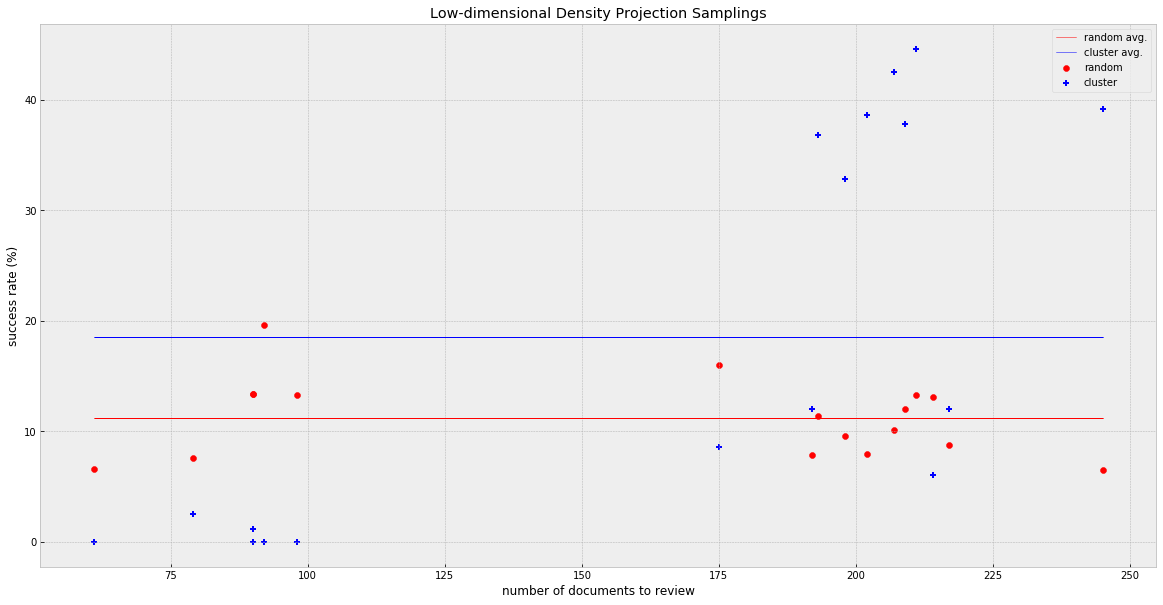

In [78]:
w2v_X = np.load(join(FEATURES_DIR, 'w2v_X.npy'))
ldds_output = ldds.LDDS(w2v_X, data_y, two_phase=True, size=1000, show=True, random_state=2018)

The graph above shows comparison of random sampling and cluster sampling at each batch with number of documents reviewed to achive success rates on y-axis. Recall, there are 1995 relevant documents in `data_y` and the total number of documents are 17879 so prevalence is ~11%. This is well reflected by the average line of random sampling demsontrating its unbiased nature. On the other hand we can see the cluster of blue points with hit rate higher than 30%, striking as high as 42%. On average, the cluster prevalence is ~18%, a +7% gain on average performance of random sampling. Further engineering, e.g. measursing batch similarities and dropping small clusters, can enhance the search for relevant documents.

One important point here is that, our comparison with random sampling is treating it with high degree of favor. Reason being the calculation of `number of docments to review` on x-axis, which is cluster size that we only are able to determine after finding applying cluster sampling. In a more fair comparison, the number of documents to review from a random batch should be unknown to random sampling.

Below we show underperformance of our approach without application of AGGC, mainly due to direct application of K-Means, which can not uncover latent thematic struture represented by documents with word2vec and use of euclidean distance instead of cosine (which works very well with word2vec features). AGGC makes K-Means job easier.

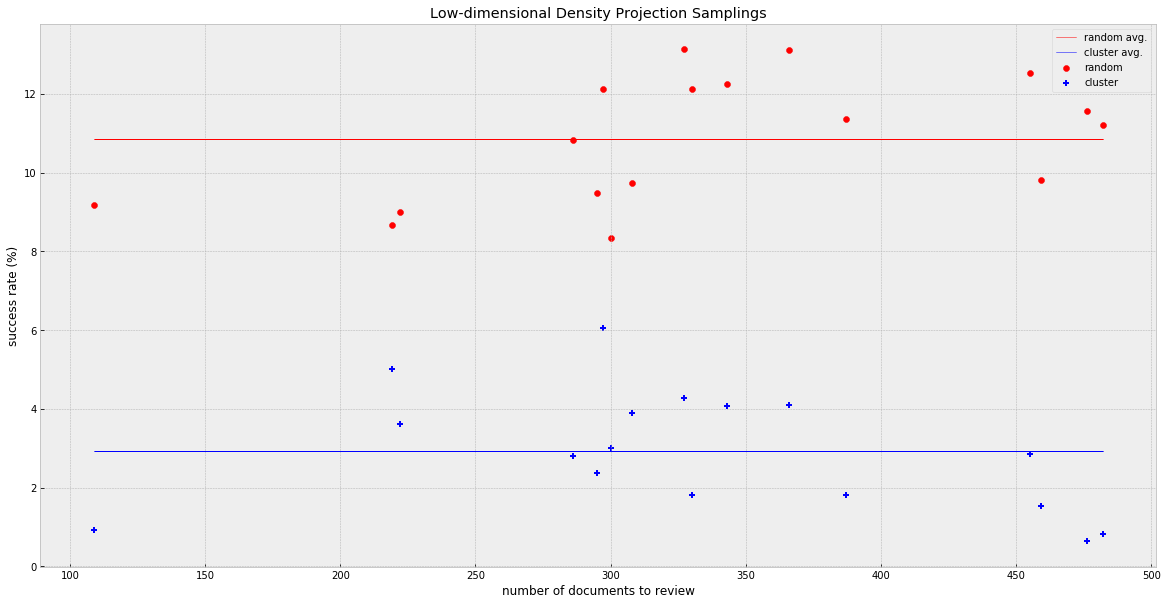

In [79]:
ldds_output = ldds.LDDS(w2v_X, data_y, two_phase=False, size=1000, show=True, random_state=2018)

## Further Thoughts, Future Direction and Additional Comments

In this notebook we presented a candidate framework $-$ a sequence of steps $-$ for predictive coding with active learning on a selected dataset of enron spam and also explained, at vert high level, a range of active learning algorithms that can be explored in future. The purpose of this work was to hint a direction that is realizable and deployable as a preliminary solution to predictive coding for EDT. The set of experiments that have been conducted in this notebook are limited due to data dependency but the scope is wide and ideas are general that can be flexibly extended to other datasets. While the results (and their optimistic values) are consequence of the data being used (spam detection is an easy task because the language and words used in spam vs. ham are distinctive enough to make it linearly separable), the framework itself is data _agnostic_. There are some practical problems, future directions and thoughts that were left undiscussed but below we will summarize few:

- **Parallel Labeling Environments and Distributed Learning** $-$ In a real-world predictive coding setting there are multiple labelers (reviewers/lawyers/oracles) working in parallel on same dataset, either on batches (e.g. EDT's optional workflow scheme) or on documents sequentially. This arises the problem of parallel labeling, whereas most of the algorithms discussed in this notebook assumed single oracle. In a pool-based active learning our decision making happens sequentially as per _one example at a time_ to optimize the learning and make effective use of active algorithms, as we aim to achieve _best learning update_ so model can make right decisions with least number of examples consumed as possible. Query happening at time $t$ has to weight for results of $t-1$ because the prior decision leads to adjustment of decision boundaries. One might be tempted to just take top-k uncertain examples depending on the algorithm used (e.g. in uncertainty sampling, take top-10 most uncertaint - distant - examples from boundary), but results have shown doing so leads to inefficient active learning performing even poor than random sampling. To solve problem we have two possible directions:
    - _Batch-mode Active Learning_ $-$ Batch-mode active learning is an extension of pool-based active learning where the goal is to form a `K` size batches at each time step to form most informative queries instead of one. Some algorithms discussed can be (and have been) extended to batch-mode but we will not cover their details here. In fact, we point the reader to an unofficial Google [repository](https://github.com/google/active-learning) on batch-mode active learning, which offers many algorithms off-the-self for experimentation.

    - _Per-Oracle Active Learning_ $-$ Active learning has seen most of its success in pool-based setting or to some extent in stream-based so it is much better to have support for pool-based scenario with same algorithms. A natural way to do this might require assigning batches to all the oracles so they have their static datasets which they can work on individually. A drawback to this approach will be that we are not making the most out of shared knowledge of oracles and also making inefficient use of active learning. Former can probably be resolved by having a final model which itself is ensemble of all models assigned per oracle. Latter is trade-off that we might have to bear as consequence of the design. In any case, with some clever implementation, pool-based active learning, sequentially, is the most efficient way of learning.


- **Semi-supervised Learning** $-$ Although we didn't covered semi-supervised active learning but it is also a promising area. Conceptually, there is some overlap between semi and active learning, comparison of US, QBC and EER have been drawn to self-training, co-training and entroyp regularization in semi-supervised learning respectively. 


- **Efficient SVM** $-$ Mentioned in active learning for imbalanced classes was a technique that sub-samples the unlabeled pool in a way that with high degree of certainty the algorithm is sampling around the border and thus making prediction on this small pool of examples to make query. This feature might become very desireable for large-scale predictions at each query step when unlabeled contains millions of examples. This approach is not only computationally efficient but data efficient as well since we only need to look around border for picking next uncertain point. Note this technique only works with C/nu-SVM implementations which has support vectors unlike SGD trained linear classifier with hinge loss.


- **Vowpal-Wabbit (VW)** $-$ VW is a proven library for large-scale machine learning and it provides utilities to make parallel learning easy manageable and has three active learning implementations 1) Cost Overlapped Active Learning (COAL), 2) Cost Cover Active Learning and 3) Agnostic Active Learning without Constraints (default). However, VW's programming interface is limited and its mainly used as command line tool. It is currently facing issues to support `pyvw` for Python 3.5 on Windows (which has been our main dev version) but its wrapper works for Python 2.7. It remains to be investigated if python wrapper supports active learning. A handy feature is daemon server which listens to a specified port and can be used interactive interface, check [here](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Using-active_interactor.py). Some useful examples can be found [here](https://github.com/VowpalWabbit/vowpal_wabbit/tree/master/python/examples). Other options include either using C# or C++ (native) programming interfaces. We also point reader to check out [this](https://www.zinkov.com/posts/2013-08-13-vowpal-tutorial/) VW tutorial, probably one of best all round coverage to different features of VW. Some interesting VW related posts can be found [here](http://fastml.com/blog/categories/vw/). Resources concerning the use of VW active learning are quite scarce. It also should be noted that VW's AL is **stream-based active learning**.

- **Deep Learning in Active Learning** $-$ There is not much evidence of such connection but in recent years there have been few works and their references and implementations are well summarized [here](https://github.com/ej0cl6/deep-active-learning). The difficulty comes from the fact that deep learning requires lots of labeled data to do a good job and active learning is all about learning with limited data. However, deep learning is equally state-of-the-art in learning representations from unlabeled data and there is myriad of work done in this paradigm. Dense representation and RNN based encoding schemes have widely been studied, so deep learning can be used as feature extractor for active learning (e.g. we demonstrated basic use of word2vec). Please note that searching phrase "Deep Active Learning" brings to a book which is about "learning" in education sector, being called with overlapping names.

- **Concept Drift** $-$ Throughout our discussion we assumed that data is static and we are not updating it, however, it is likely that data comes in several batches over a certain period of time which induces a phenomenon called [_concept drift_](https://www.cs.waikato.ac.nz/~abifet/PAKDD2011/). A lot of research has been done to cater for it in supervised learning but its less clear for active learning. It can be argued that the problem is similar to solving it as stream-based active learning but our interest is pool-based scenario. It also remains unclear how adverse effects can concept drift have on active learning. If the newly arriving data points have samples that are close to current decision boundary or to any decision boundary in the history of queries iteration then the likelhood of having different model at current time is very much possible and this also means that if we had these points at some point earlier in time then we might have made different labeling request rendering currently labeled request rather useless or inefficient.

- **Relevance Score, Relevance Feedback and Learn2Rank** $-$ We discussed it mildly during the demo but we point it out explicitly here to emphasize. The concept of [_relevance score_](https://blog.cluster-text.com/2013/10/15/the-meaning-of-relevance-score/) and sorting the dataset based on it is widely used in predictive coding which relates the problem to well studied _learning to rank_ field. Ranking problems are generaly studied for information retrieval (check [this](https://www.nowpublishers.com/article/DownloadSummary/INR-016) report for detailed introduction) and most widely used in search engines where each query has different relevancy to the web pages and the goal is to rank most likely matches at top so precision is very high on initial pages but it drops drastically as user explores later result pages. One work that ties active learning to ranking has been proposed [here](https://www.researchgate.net/profile/Faiza_Dammak2/publication/289130180_Active_Learning_to_Rank_Method_for_Documents_Retrieval/links/5689a58108ae1e63f1f8fd7a/Active-Learning-to-Rank-Method-for-Documents-Retrieval.pdf). In our work we proxied it with ranking documents based on model predictions during review phase as "Prioritzed Review Progress" but we are unclear if its the right way to use it. So the question remains, how learn2rank is associated with CAL and predictive coding, is there is any association or not?

- **Active Learning Metrics** $-$ The evaluation metrics we discussed are mainly used in supervised learning and for sake of comparisons they are also adopted in active learning to demonstrate learning progress with number of queries (learning curve), which is good for training error but not reflective of generalization loss. We showed _progressive validation_ (PR) as possible alternative to truly measure model performance on unseen and difficult examples. It is promising but strict and biased in its selection due to sampling around the border in uncertain region. A more relaxed and unbiased approach should sample point at random at PR frequency (`pr_rate`), ask for their label and use them as test set. In such scenario, clusters offer a much more feasible solution where cluster centers are queired, a random sample close to center can be requested for query and use as test set. Though we didn't covered some of metrics that were experimented during this work, we will briefly describe them here for further investigation in future:
    - Per-Query Correctness: The idea is very basic, it notes model's current prediction on query example and compare it with oracle label, if two agree on the label, we count it. In the end this will be equal to _total agreements $/$ number of queries_. It can also be varied to focus on positive (relevant) examples only as _total agreements when model predicted 1 and oracle labeled 1 $/$ total 1s labeled by oracle_. Note that second can be greater than one if model predictions are highly biased to predict 1.
    - Per-Query Cohen-Kappa: Here we accumulate model predictions on current query before training on it and also oracle label. With each query step we compute Cohen-Kappa agreement coefficient which shows over time that model is able to learn underlying oracle philosphy for labeling.

- These metrics suffer from high variance due to sampling in uncertain region and often reflects that model is _probably not learning_ which is not true because often it is predicting with high performance on unlabeled pool. Investigation of ideal metrics for active model evaluation remains an area to improve. 

## Acknowledgments

We are highly indebted to Burr Settles active learning survey (Settles, 2009) and subsequent book (Settles, 2012). We also want to thank `libact` authors and developers for developing an excellent library that makes active learning very much accessible in Python. We also acknowledge the use of `gensim` and `scikit-learn` for feature engineering and, modeling respectively and `matplotlib` for visualizations.

## References

S. Hanneke. [_Theoretical Foundations of Active Learning_](http://www.stevehanneke.com/docs/thesis.pdf). PhD thesis, Carnegie Mellon University, 2009.

Settles, Burr. [Active learning](https://www.morganclaypool.com/doi/abs/10.2200/S00429ED1V01Y201207AIM018). _Synthesis Lectures on Artificial Intelligence and Machine Learning_ 6, no. 1 (2012): 1-114.

B. Settles. [Active learning literature survey](http://www.academia.edu/download/30743174/settles_active_learning.pdf). Computer Sciences Technical Report 1648, University of Wisconsin–Madison, 2009.

S. Ertekin, J. Huang, L. Bottou, and L. Giles. [Learning on the border: active learning in imbalanced data classification](https://clgiles.ist.psu.edu/pubs/CIKM-2007-learning-border.pdf). In _Proceedings of the sixteenth ACM conference on Conference on information and knowledge management_, pp. 127-136. ACM, 2007.

B. Dimm. [TAR 3.0 and Training of Predictive Coding Systems](http://www.cluster-text.com/papers/TAR_3_and_training_predictive_coding.pdf). 2015.

D. D. Lewis. Continuous Multimodal Learning (CMML): A new approach to machine learning in text analytics workflows. Whitepaper, Brainspace, 2017.